# External independent tests report 2016-2023 (part 1)

![VNO-ZNO-po-istorii-Ukrainyi-v-2017-godu-1024x6825a2548cee80f9-4-690x346](VNO-ZNO-po-istorii-Ukrainyi-v-2017-godu-1024x6825a2548cee80f9-4-690x346.jpg)


Image source: [uatv.ua](https://uatv.ua/en/registration-for-external-independent-testing-2018-starts-today-in-ukraine/)

## Background
The aim of this study was to analyze the performance of Ukrainian school graduates in the External Independent Tests (EIT/NMT) from 2016 to 2023, and to provide insights into the factors that may affect their results. To achieve this goal, data was collected from the Ukrainian Center for Educational Quality Assessment (UCEQA) website and meticulously cleaned. Moreover, information about the administrative-territorial structure was added to ensure that the analysis takes into account regional differences. The quality of the source data was also verified to ensure its reliability.

The report provides comprehensive and detailed analyses of the data, including graphs and charts depicting participant performance metrics, distribution by various criteria, and geospatial metrics. These analyses aim to shed light on the strengths and weaknesses of the current EIT system, highlight areas for improvement, and provide recommendations for policymakers and educators.

Overall, this study serves as a valuable resource for anyone interested in understanding the EIT results, as well as for those seeking to improve the educational system in the country.

## Load R libraries

Loading R libraries

In [4]:
library(tidyverse)
library(data.table)
library(ggplot2)

## Read Data

Read CSV file from source into a datatable. Raw data from [UCEQA](https://zno.testportal.com.ua/opendata) has been processed,enriched, and cleaned by me. R scripts for data prep and cleansing you can find in [git](https://github.com/sapotec/eit-ukraine)

In [5]:
zno_raw <- fread(
  cmd = "unzip -cq outputs/ZNO_2016+_raw_data.zip",
  na.strings = "", dec = ".", encoding = "UTF-8", quote = ""
)


## Data preparation
Compose datasets for visualization


Explore source dataset. Check values consistency within columns

In [6]:
zno <- zno_raw %>%
  mutate(across(c(matches("name$|test$|lang$|status$")), as.factor)) %>%
  relocate(classprofilename, classlangname, .after = tertypename)


Pivot dataset to long. It contains info about test results by subject,gender,settlement type, and students grade

In [7]:
zno_long_teststatus <- zno %>%
  select(
    year, outid, birth, sextypename,
    tertypename, regtypename,
    matches("test$"), matches("teststatus$")
  ) %>%
  select(-c(msttest, mstteststatus)) %>%
  filter(if_any(matches("teststatus$"), ~ .x != "Не з'явився")) %>%
  melt(
    id.vars = c(
      "year", "outid", "birth", "sextypename",
      "tertypename", "regtypename"
    ), na.rm = TRUE,
    measure.vars = patterns(
      test = "test$",
      status = "teststatus$"
    ), value.factor = TRUE
  ) %>%
  select(-variable) %>%
  filter(status != "Не з'явився")


Plot options

In [21]:
options(
  scipen = 5, repr.plot.width = 12,
  repr.plot.height = 8, repr.plot.res = 300
)

capt <- "Data source:UCEQA(testportal.gov.ua) | Created by: Taras Nyzhnyk"

caption <- labs(caption = capt)

general_plot_config <- theme_minimal() +
  theme(
    # plot title and caption settings
    plot.title = element_text(
      size = 16, face = "bold",
      hjust = 0.5, margin = margin(0, 0, 0, 0)
    ),
    plot.caption = element_text(color = "#757575"),
    plot.caption.position = "plot",
    # axis titles
    axis.title = element_text(size = 12, face = "bold"),
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    # axis text
    axis.text.x = element_text(margin = margin(-3, 0, 0, 0)),
    # legend settings
    legend.title = element_text(size = 8, face = "bold"),
    legend.position = "top",
    legend.text = element_text(size = 8),
    legend.key.size = unit(16, "pt"),
    # strip for facets
    strip.text = element_text(size = 10, face = "bold")
  )


Constant variables

In [22]:
failed_statuses <- c("Не з'явився", "Не обрано 100-200", "Анульовано")

age_buckets <- c(12, 15, 18, 20, 25, 30, 40, 50, Inf)

age_buckets_labels <- c(
  "13-15 років", "16-18 років", "19-20 років",
  "21-25 років", "26-30 років", "31-40 років",
  "41-50 років", "50+ років"
)

levels_grad <- c(
  "Студент закладу вищої-фахової передвищої освіти",
  "Студент закладу вищої освіти", "Учень закладу професійної освіти",
  "Випускник минулих років", "Випускник поточного року"
)

levels_m_subj <- c(
  "Українська мова і література",
  "Історія України",
  "Математика"
)

levels_n_subj <- c("Фізика", "Хімія", "Біологія", "Географія")

levels_l_subj <- c(
  "Українська мова", "Англійська мова", "Французька мова",
  "Німецька мова", "Іспанська мова", "Російська мова"
)


## 1. Students metrics and distributions

### 1.1 Number of students that take at least one exam

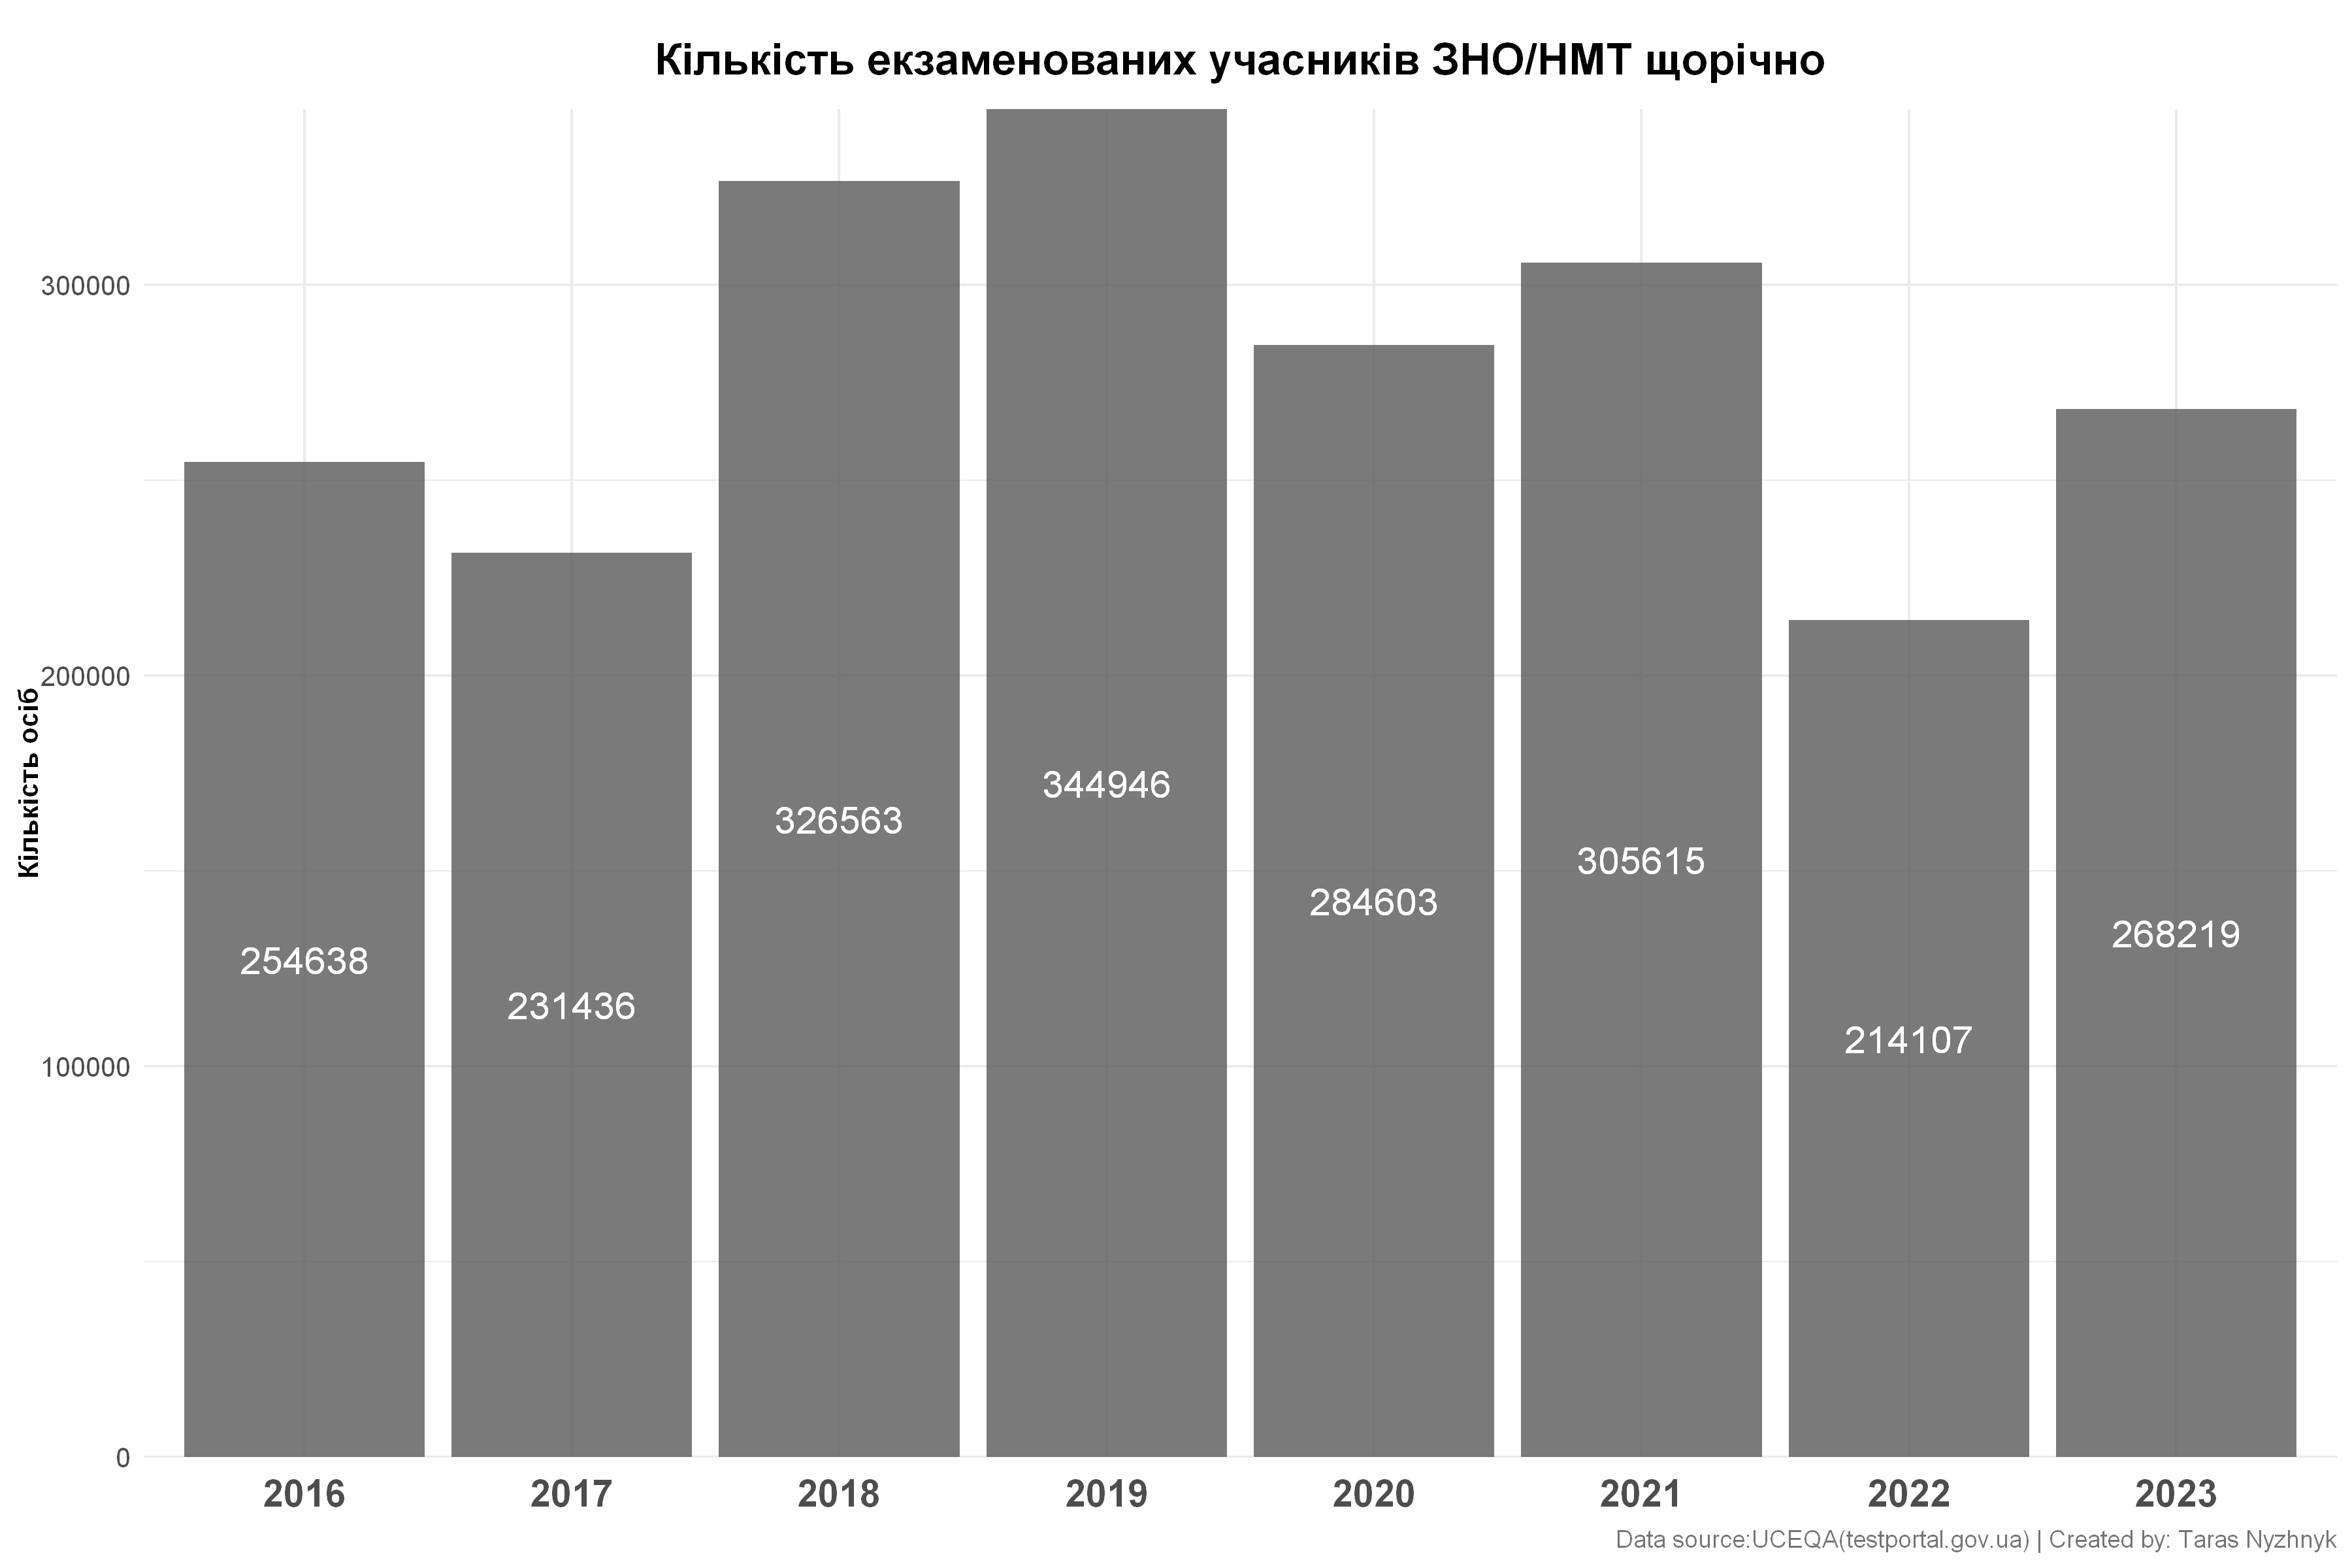

In [23]:
total_students <- zno_long_teststatus %>%
  group_by(year) %>%
  summarize(students = n_distinct(outid), .groups = "drop")

ggplot(total_students) +
  aes(x = factor(year), y = students, label = students) +
  geom_bar(
    stat = "identity",
    position = position_dodge2(
      width = 0.5, preserve = "single"
    ),
    alpha = 0.8
  ) +
  geom_text(
    size = 5,
    position = position_stack(vjust = 0.5),
    color = "white"
  ) +
  labs(y = "Кількість осіб") +
  scale_y_continuous(expand = c(0, 0)) +
  ggtitle("Кількість екзаменованих учасників ЗНО/НМТ щорічно") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(10, 0, 10, 0)),
    axis.title.y = element_text(size = 10, angle = 90),
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(
      size = 14, face = "bold",
      margin = margin(5, 5, 0, 0)
    )
  )


### 1.2  Proportion students by graduate status

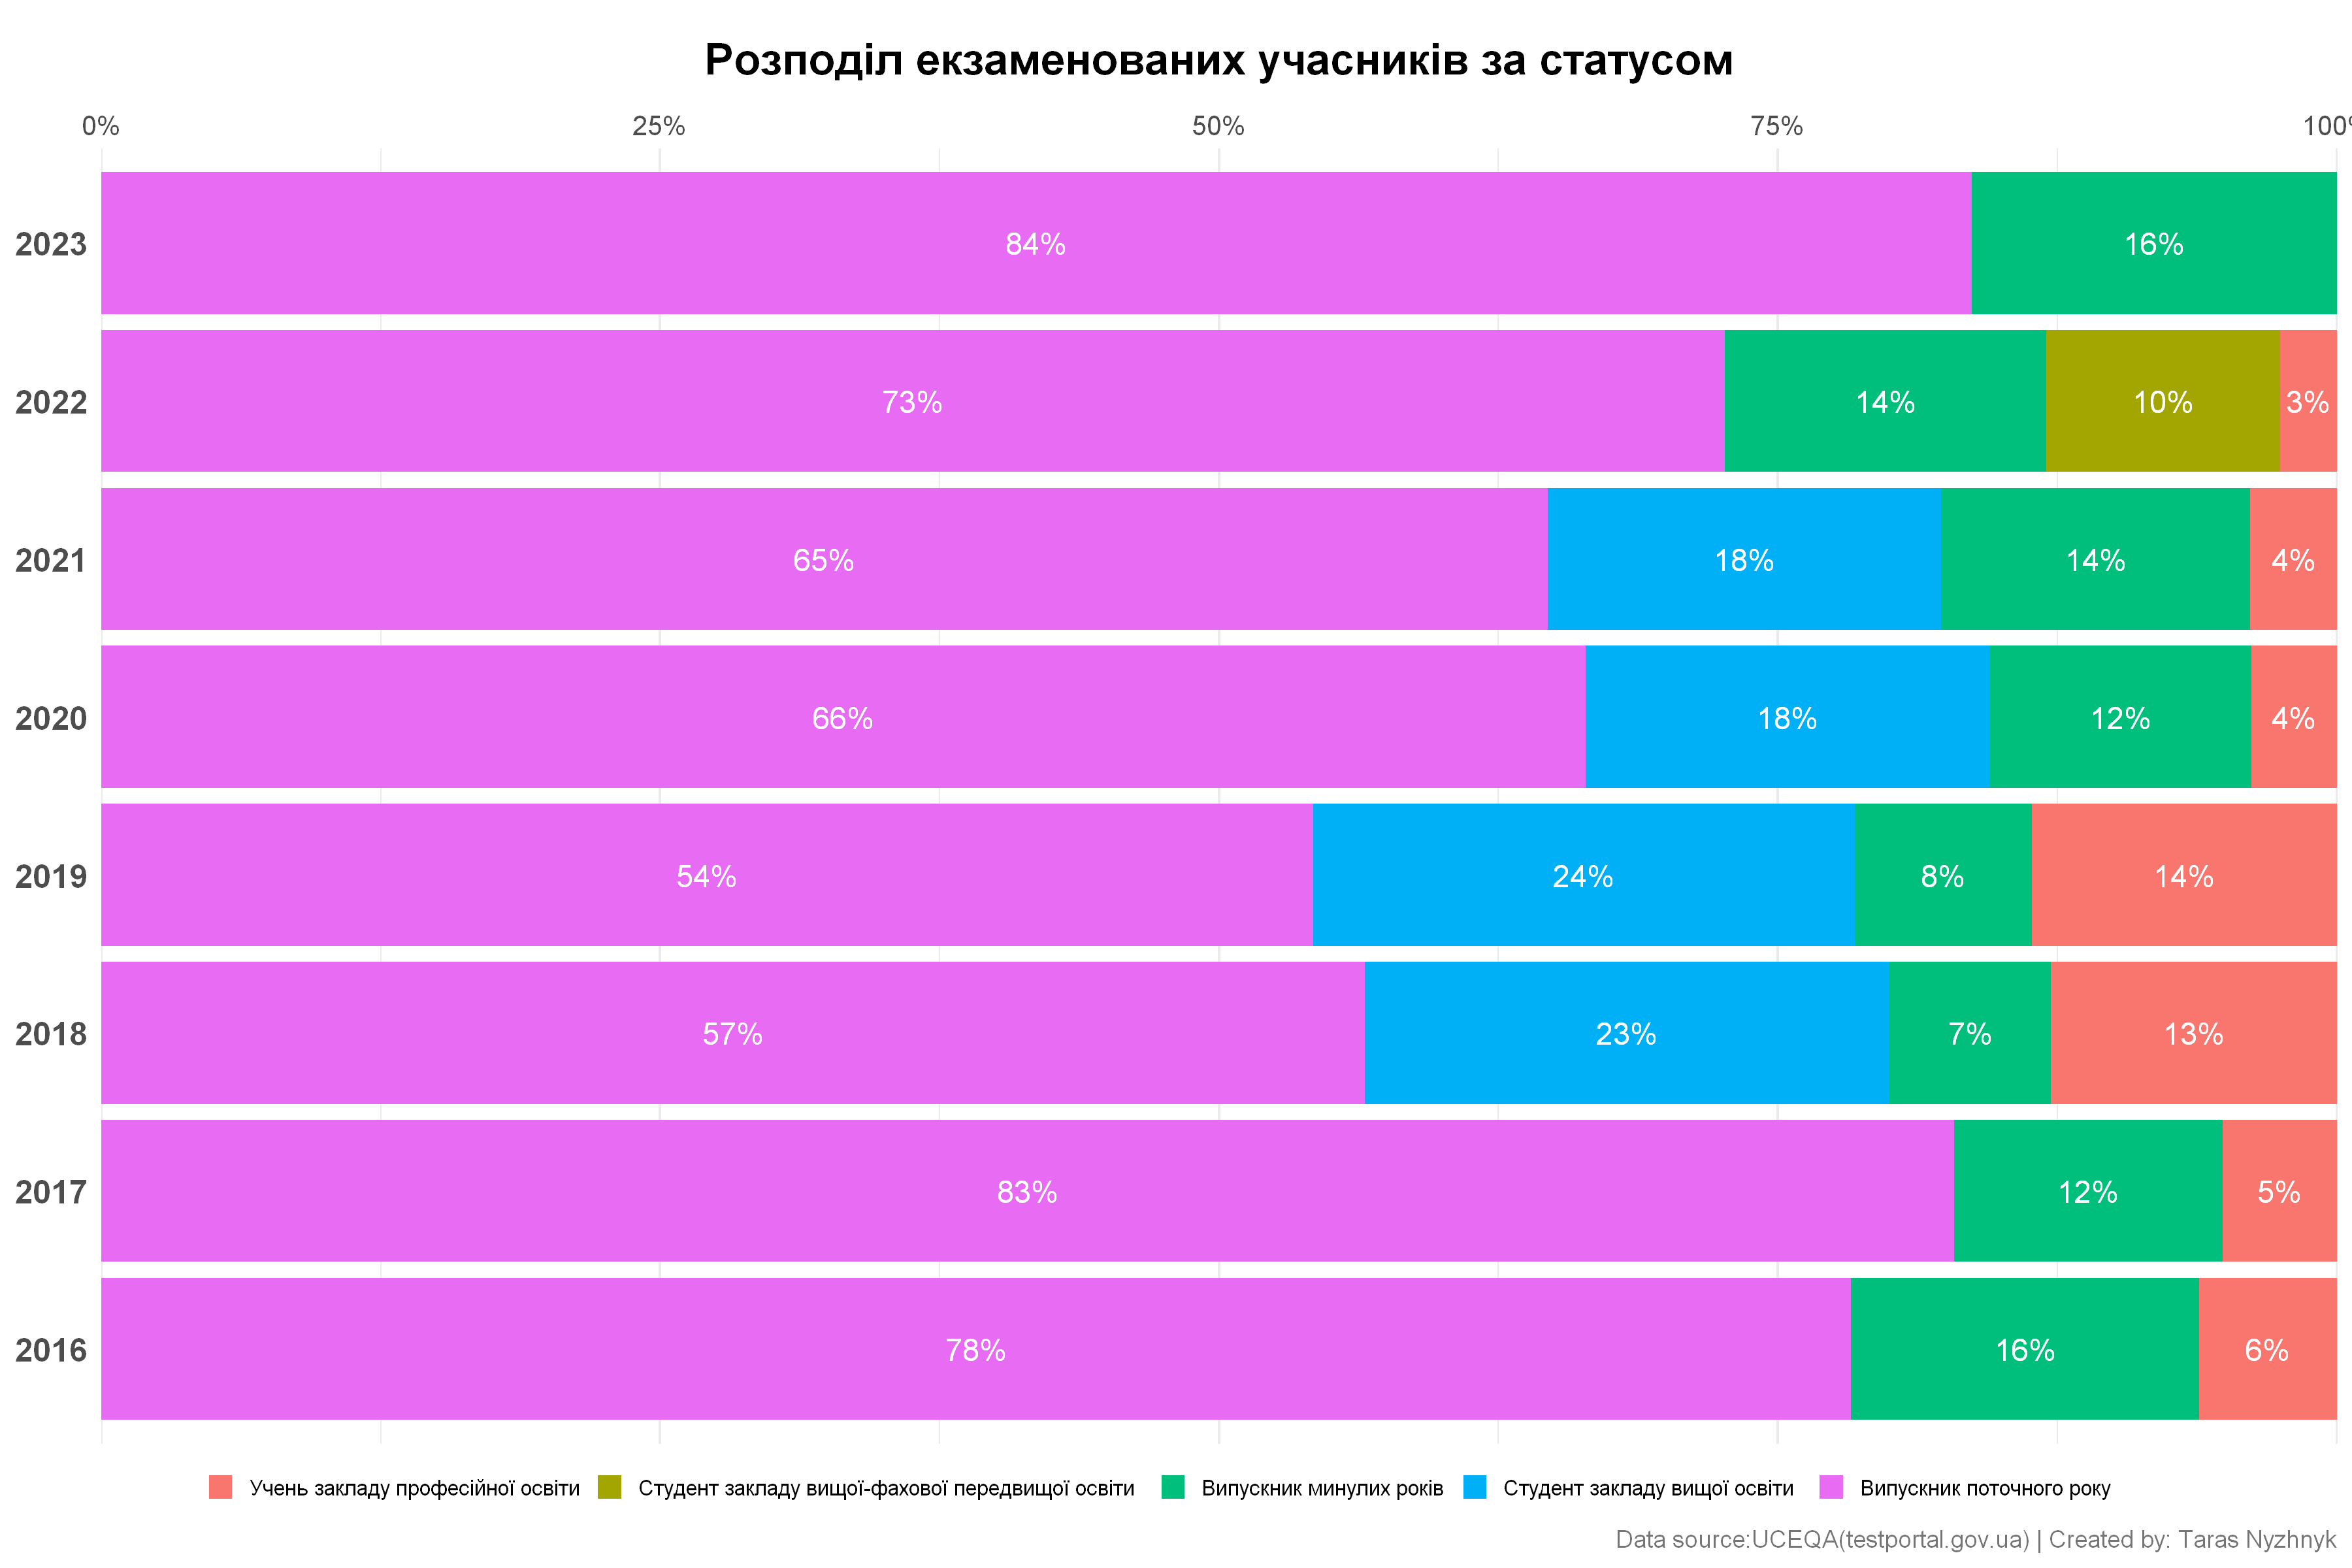

In [24]:
total_students_status <- zno_long_teststatus %>%
  group_by(year, regtypename) %>%
  summarize(students = n_distinct(outid), .groups = "drop_last") %>%
  mutate(total_students = sum(students))

ggplot(total_students_status) +
  aes(
    x = factor(year), y = students / total_students,
    fill = forcats::fct_reorder(regtypename, students / total_students)
  ) +
  geom_bar(position = position_fill(), stat = "identity") +
  scale_y_continuous(
    labels = scales::percent,
    position = "right",
    expand = c(0, 0)
  ) +
  geom_text(
    aes(
      label = scales::percent(students / total_students, accuracy = 1)
    ),
    size = 4,
    position = position_fill(vjust = 0.5),
    color = "white"
  ) +
  labs(fill = "Статус учасника") +
  ggtitle("Розподіл екзаменованих учасників за статусом") +
  coord_flip() +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(10, 0, 10, 0)),
    axis.title = element_text(size = 16),
    axis.text.x = element_text(size = 10),
    axis.text.y = element_text(size = 12, face = "bold"),
    legend.title = element_blank(),
    legend.position = "bottom",
    legend.key.size = unit(10, "pt"),
    legend.margin = margin(0, 50, 5, 0)
  )


### 1.3 Distribution by gender

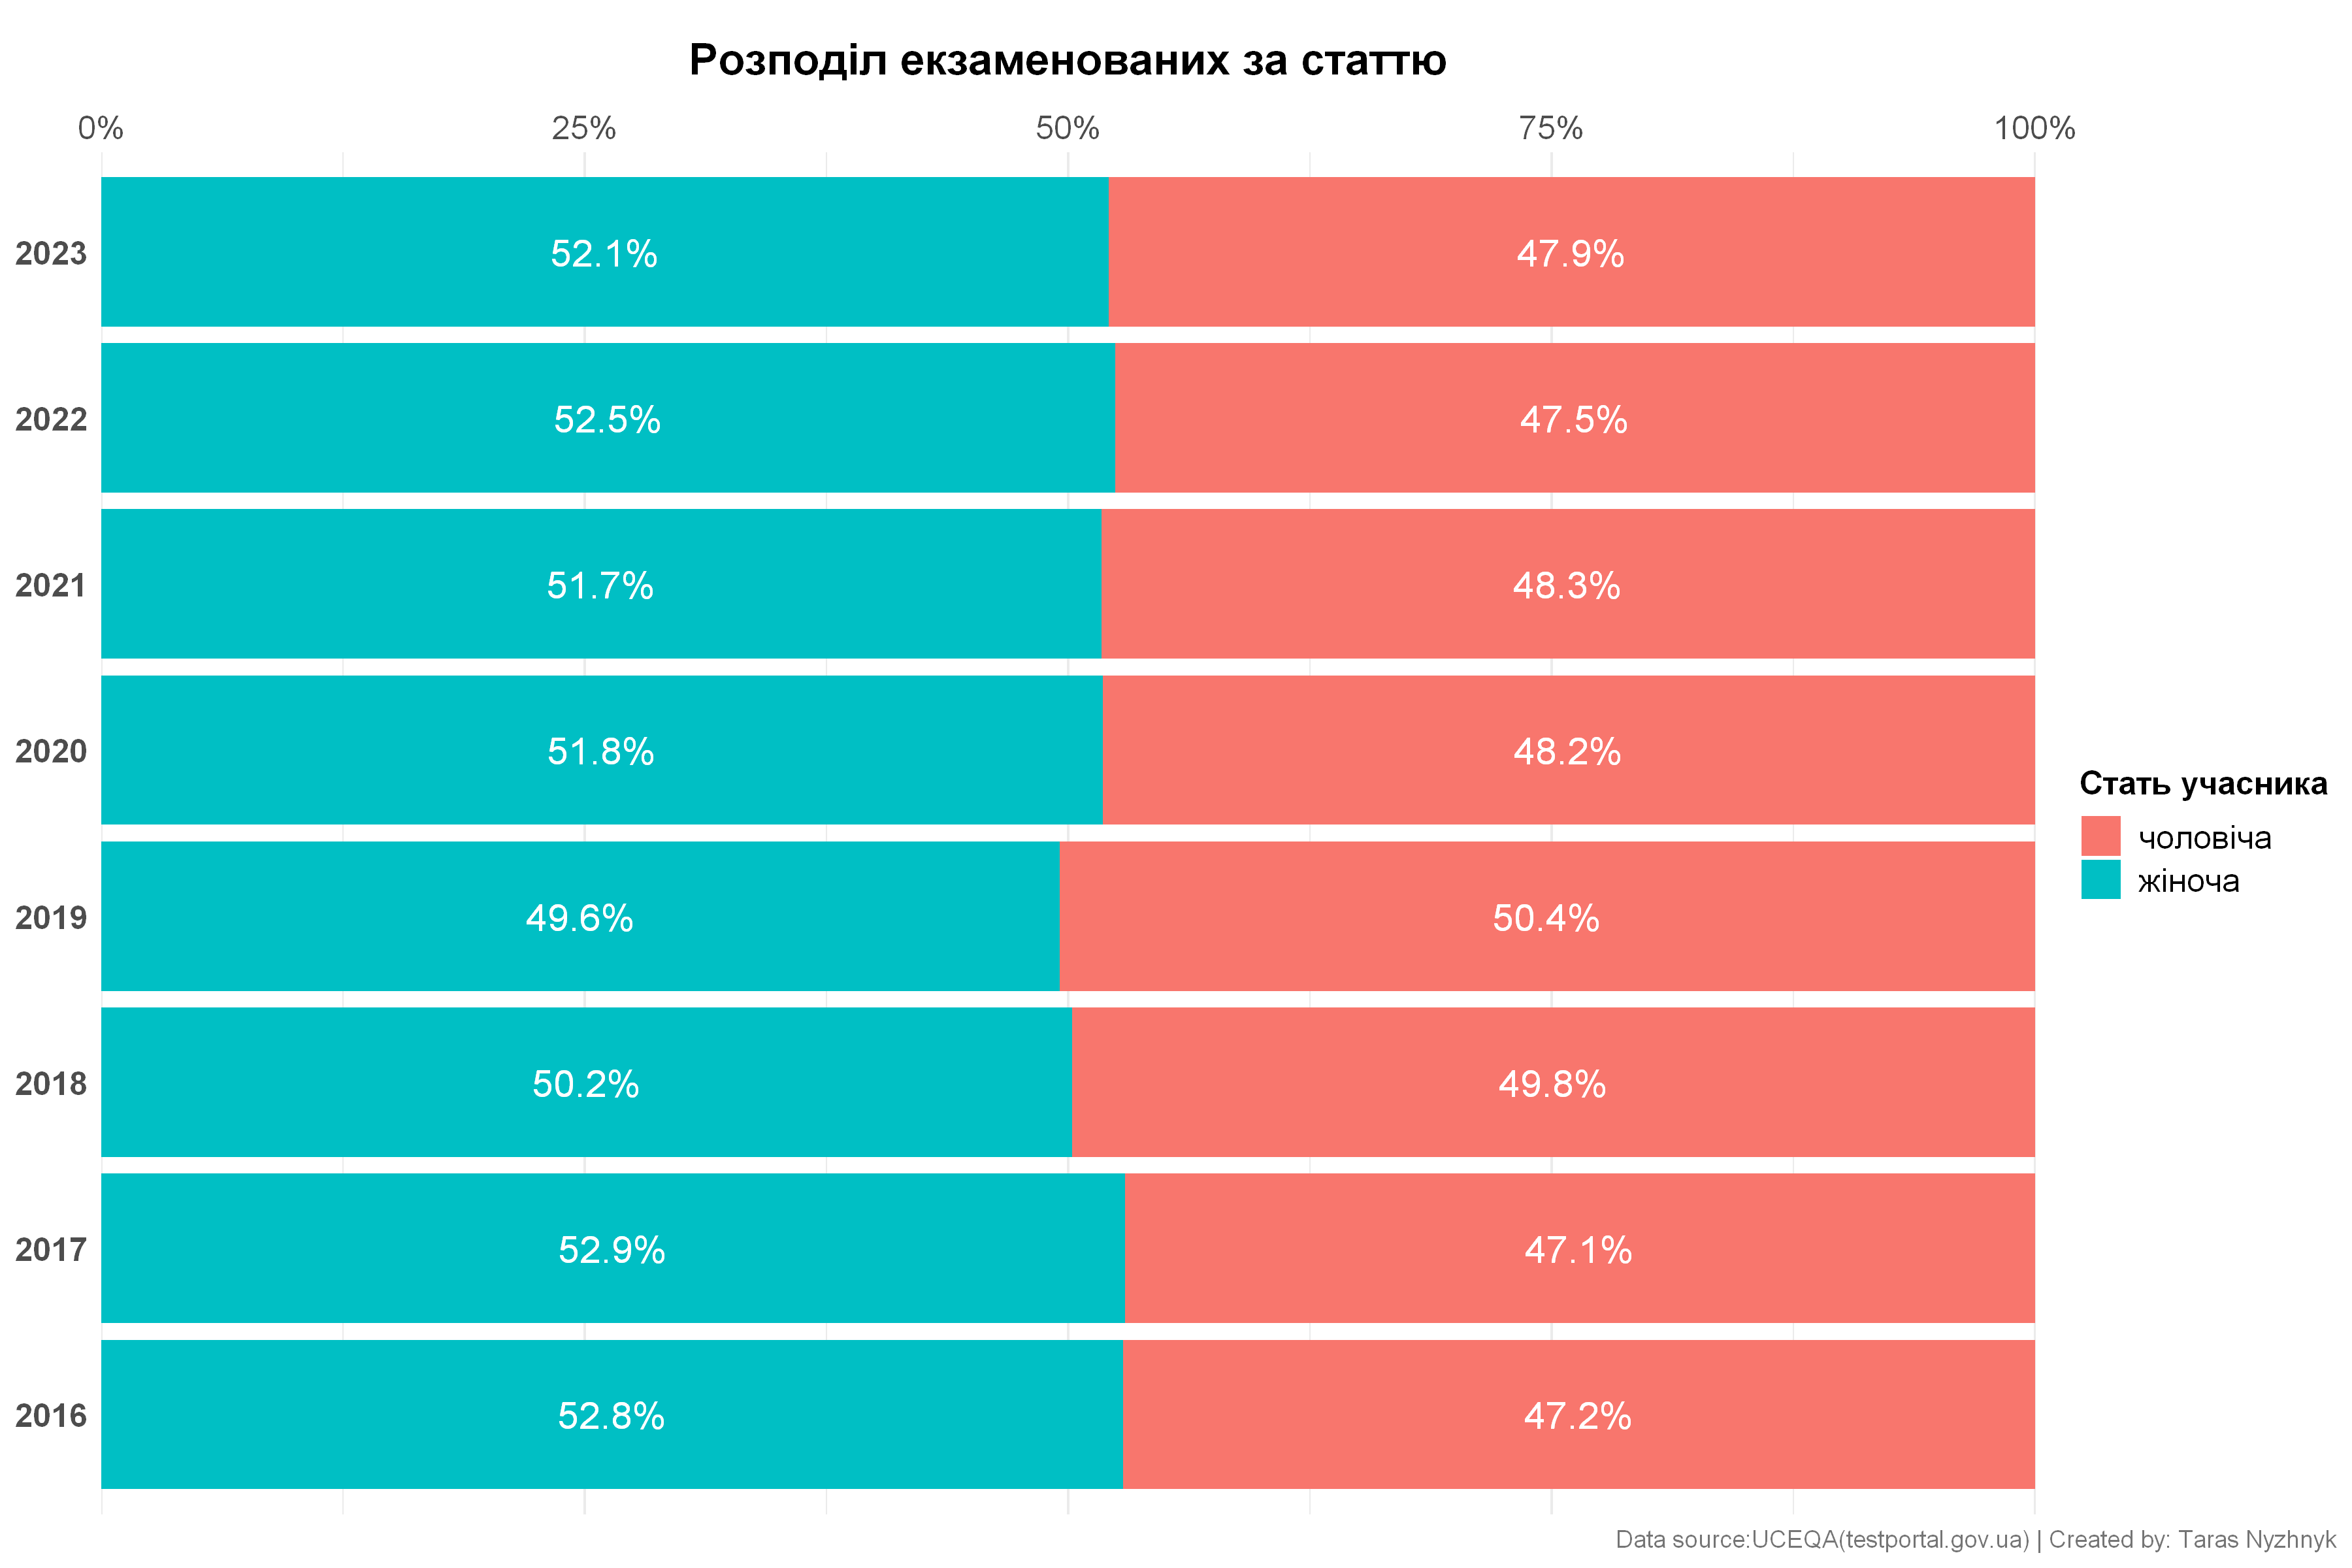

In [25]:
total_students_sextype <- zno_long_teststatus %>%
  group_by(year, sextypename) %>%
  summarize(students = n_distinct(outid), .groups = "drop_last") %>%
  mutate(total_students = sum(students))

ggplot(total_students_sextype) +
  aes(
    x = factor(year), y = students / total_students,
    fill = forcats::fct_reorder(sextypename, students / total_students)
  ) +
  geom_bar(position = position_fill(), stat = "identity") +
  coord_flip() +
  scale_y_continuous(
    labels = scales::percent,
    position = "right",
    expand = c(0, 0)
  ) +
  geom_text(
    aes(
      label = scales::percent(students / total_students, accuracy = 0.1)
    ),
    size = 5,
    position = position_fill(vjust = 0.5),
    color = "white"
  ) +
  labs(fill = "Стать учасника") +
  ggtitle("Розподіл екзаменованих за статтю") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(10, 0, 10, 0)),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12, face = "bold"),
    legend.title = element_text(size = 12),
    legend.position = "right",
    legend.text = element_text(size = 12)
  )


### 1.4 Distribution by settlement type

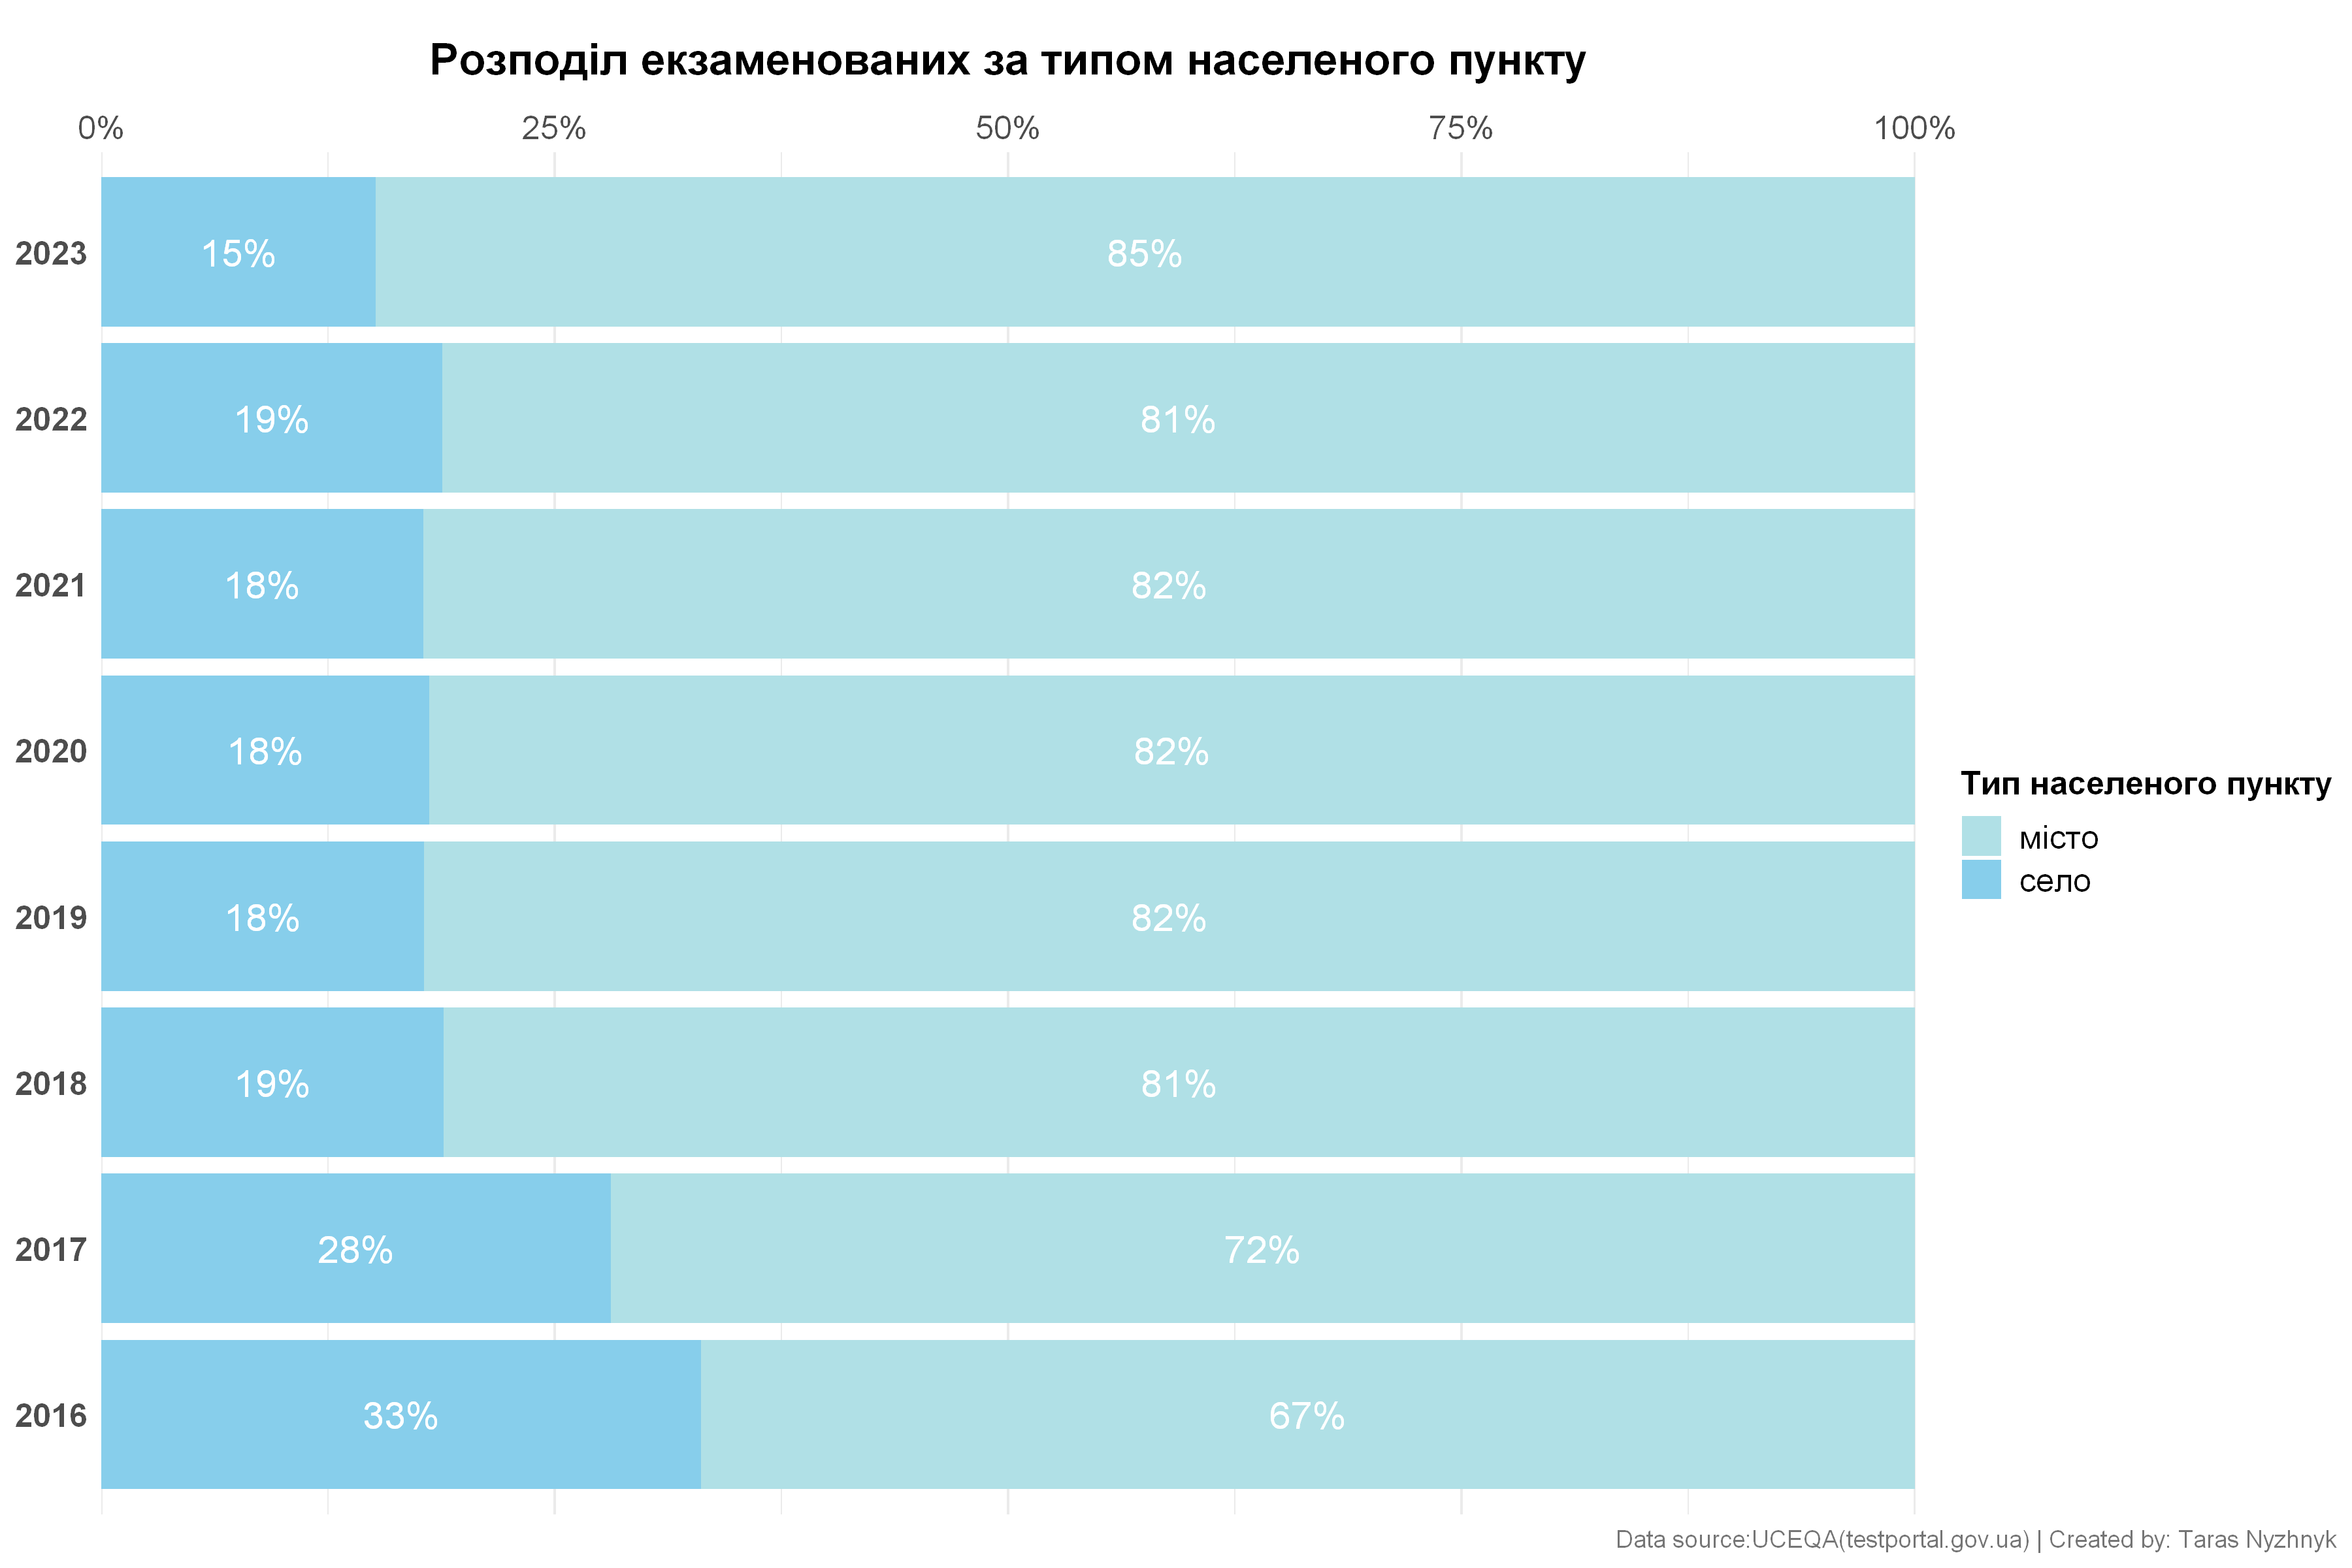

In [26]:
total_students_settlement <- zno_long_teststatus %>%
  group_by(year, tertypename) %>%
  summarize(students = n_distinct(outid), .groups = "drop_last") %>%
  mutate(total_students = sum(students))

ggplot(total_students_settlement) +
  aes(x = factor(year), y = students / total_students, fill = tertypename) +
  geom_bar(position = position_fill(), stat = "identity") +
  coord_flip() +
  scale_y_continuous(
    labels = scales::percent,
    position = "right",
    expand = c(0, 0)
  ) +
  geom_text(
    aes(
      label = scales::percent(students / total_students, accuracy = 1)
    ),
    size = 5, position = position_fill(vjust = 0.5), color = "white"
  ) +
  labs(fill = "Тип населеного пункту") +
  scale_fill_manual(values = c("#B0E0E6", "#87CEEB")) +
  ggtitle("Розподіл екзаменованих за типом населеного пункту") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(10, 0, 10, 0)),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12)
  )


### 1.5 Number of students by age and gender

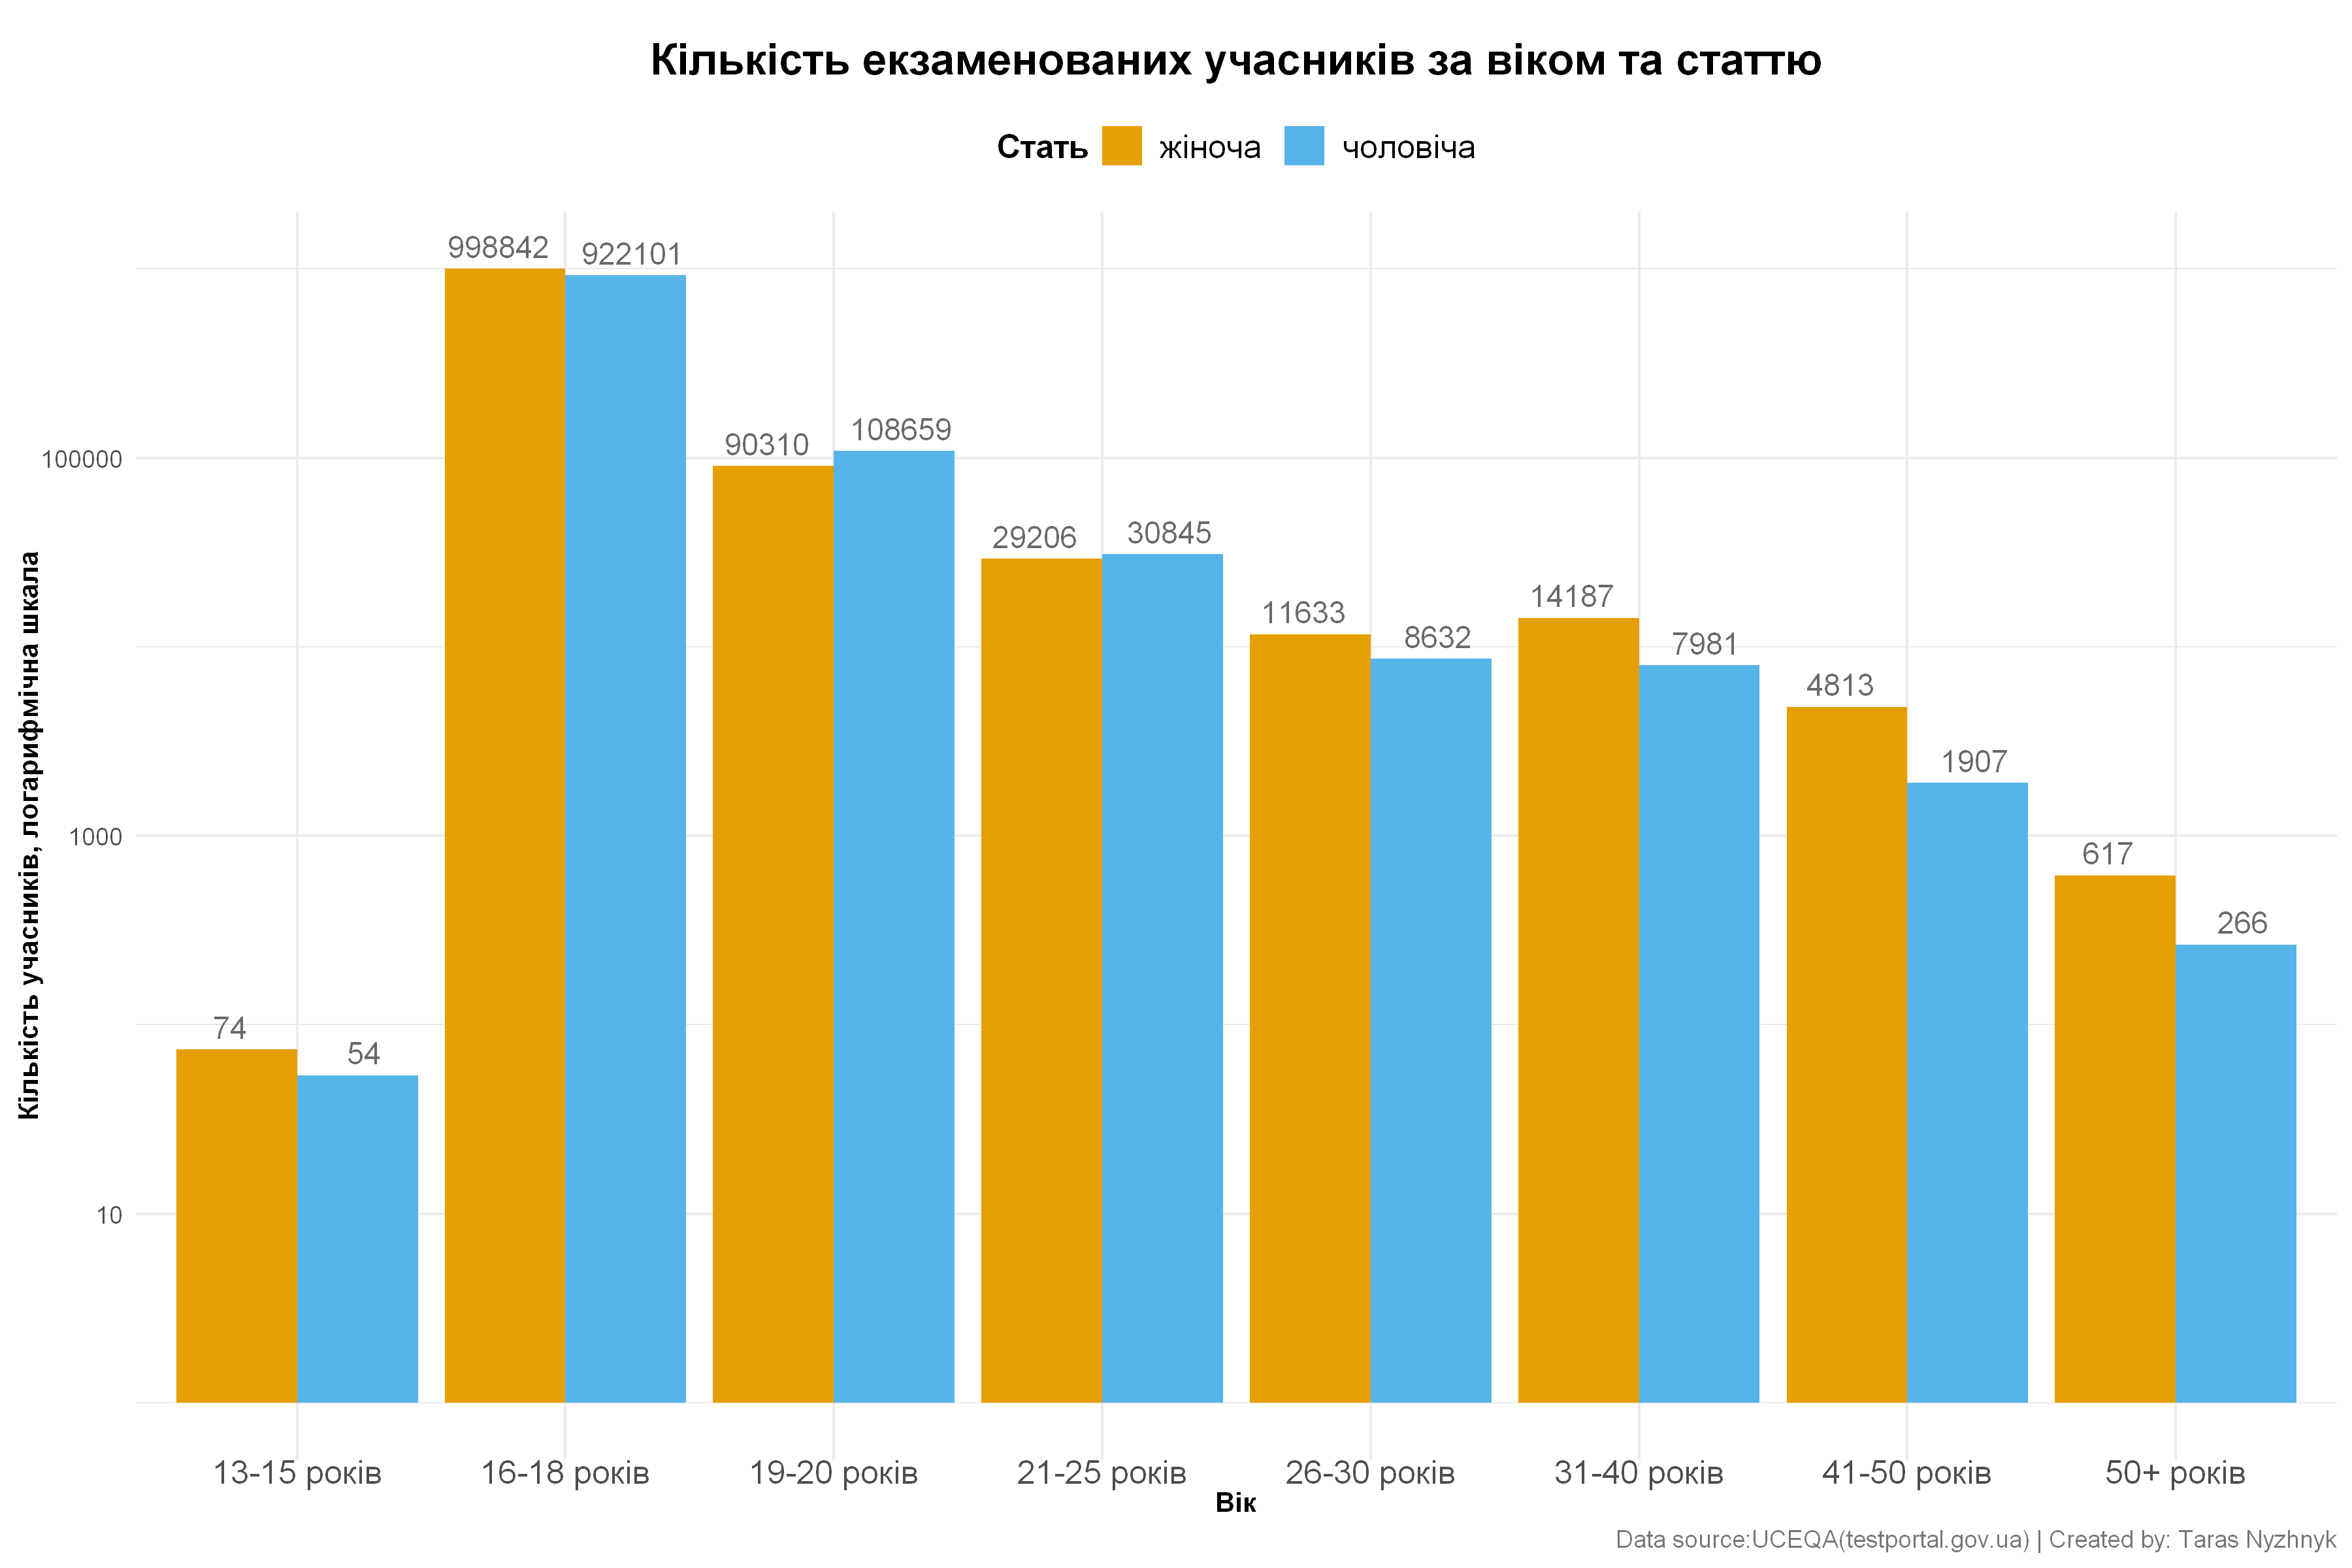

In [27]:
total_students_sextype_age <- zno_long_teststatus %>%
  mutate(
    age = cut(
      year - birth,
      breaks = age_buckets,
      labels = age_buckets_labels
    )
  ) %>%
  group_by(age, sextypename) %>%
  summarize(students = n_distinct(outid), .groups = "drop")

ggplot(total_students_sextype_age) +
  aes(x = age, y = students, fill = sextypename) +
  geom_col(position = position_dodge()) +
  geom_text(aes(label = students),
    size = 4,
    position = position_dodge(width = 1), vjust = -0.5, color = "#696969"
  ) +
  scale_y_log10() +
  labs(
    x = "Вік",
    y = "Кількість учасників, логарифмічна шкала",
    fill = "Стать"
  ) +
  scale_fill_manual(values = c("#E69F00", "#56B4E9")) +
  ggtitle("Кількість екзаменованих учасників за віком та статтю") +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(margin = margin(10, 0, 10, 0)),
    axis.title.x = element_text(size = 10),
    axis.title.y = element_text(size = 10, angle = 90),
    axis.text.x = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12)
  )


### 1.6 Distribution by gender and test status

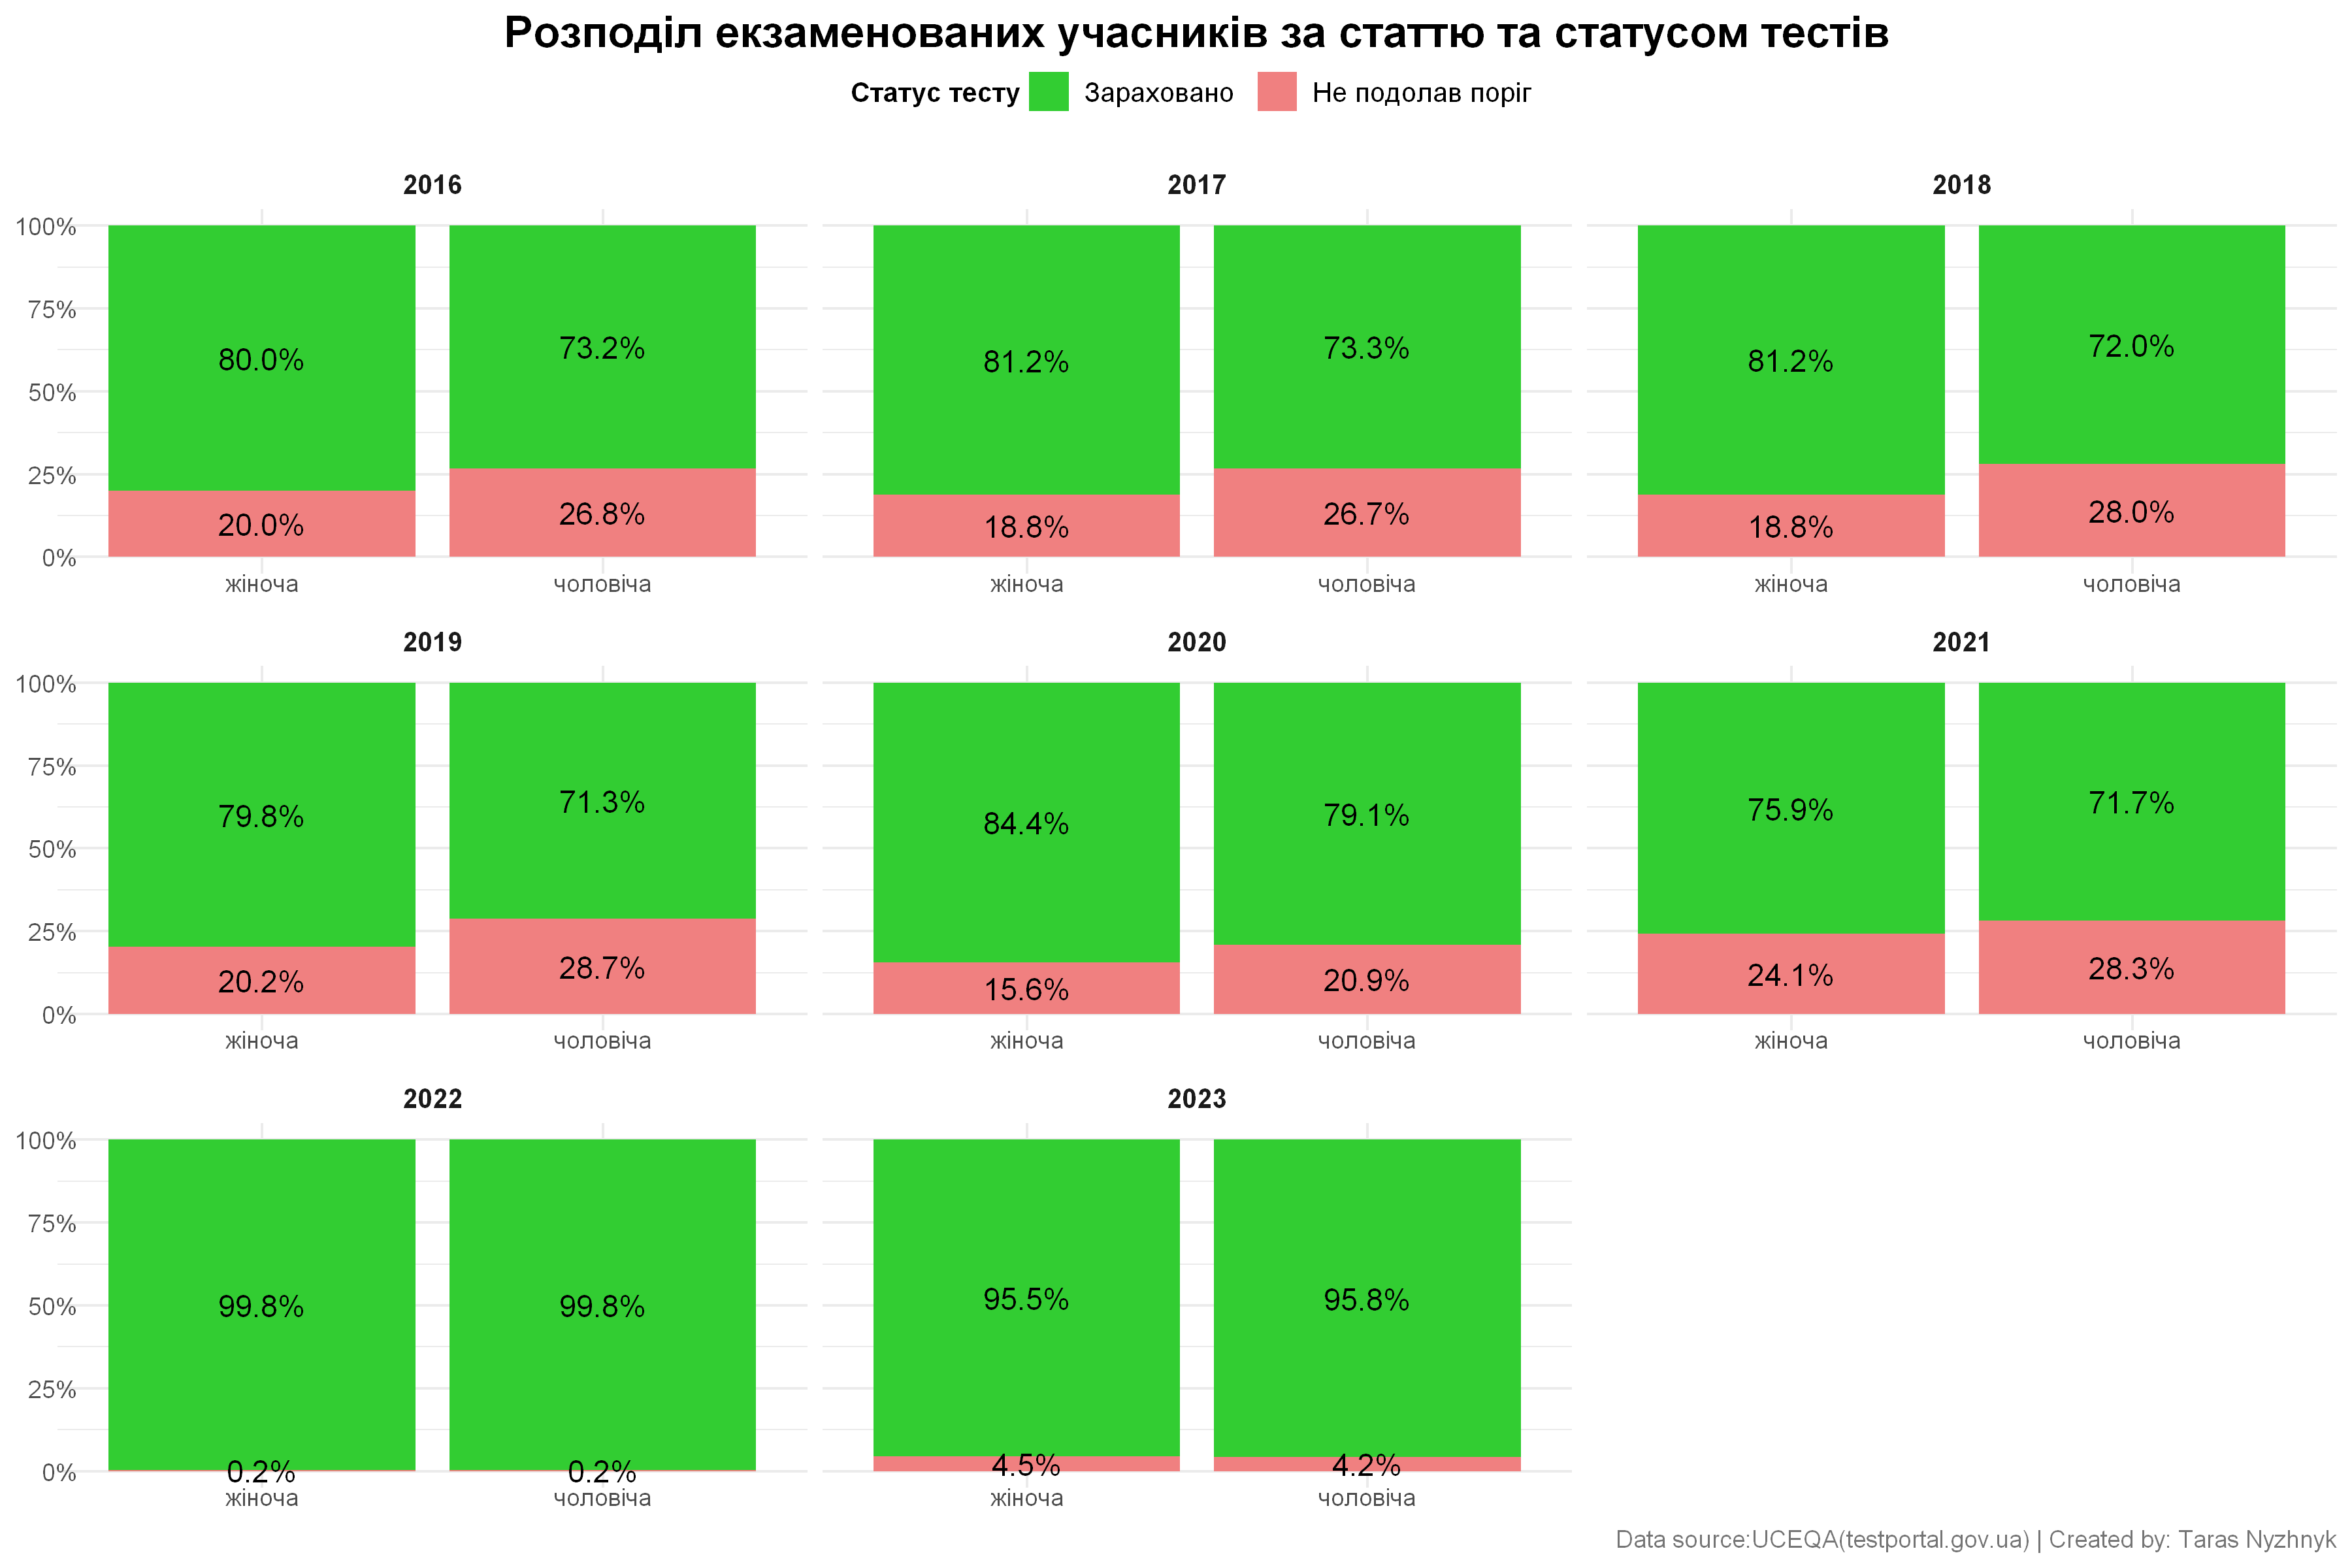

In [28]:
total_students_sex_teststatus <- zno_long_teststatus %>%
  filter(!status %in% failed_statuses) %>%
  group_by(year, sextypename, status) %>%
  summarize(students = n_distinct(outid), .groups = "drop_last") %>%
  mutate(total_students = sum(students))

ggplot(total_students_sex_teststatus) +
  aes(x = sextypename, y = students / total_students, fill = status) +
  geom_col(position = position_fill()) +
  geom_text(
    aes(
      label = scales::percent(students / total_students, accuracy = 0.1)
    ),
    size = 4,
    position = position_fill(vjust = 0.5)
  ) +
  scale_y_continuous(labels = scales::percent) +
  labs(fill = "Статус тесту") +
  scale_fill_manual(values = c("#32CD32", "#F08080")) +
  ggtitle("Розподіл екзаменованих учасників за статтю та статусом тестів") +
  facet_wrap(~year, scales = "free_x", ncol = 3) +
  caption +
  general_plot_config +
  theme(
    axis.text.y = element_text(margin = margin(0, -10, 0, 0)),
    legend.position = "top",
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 10)
  )


### 1.7 Distribution by gender and graduate status

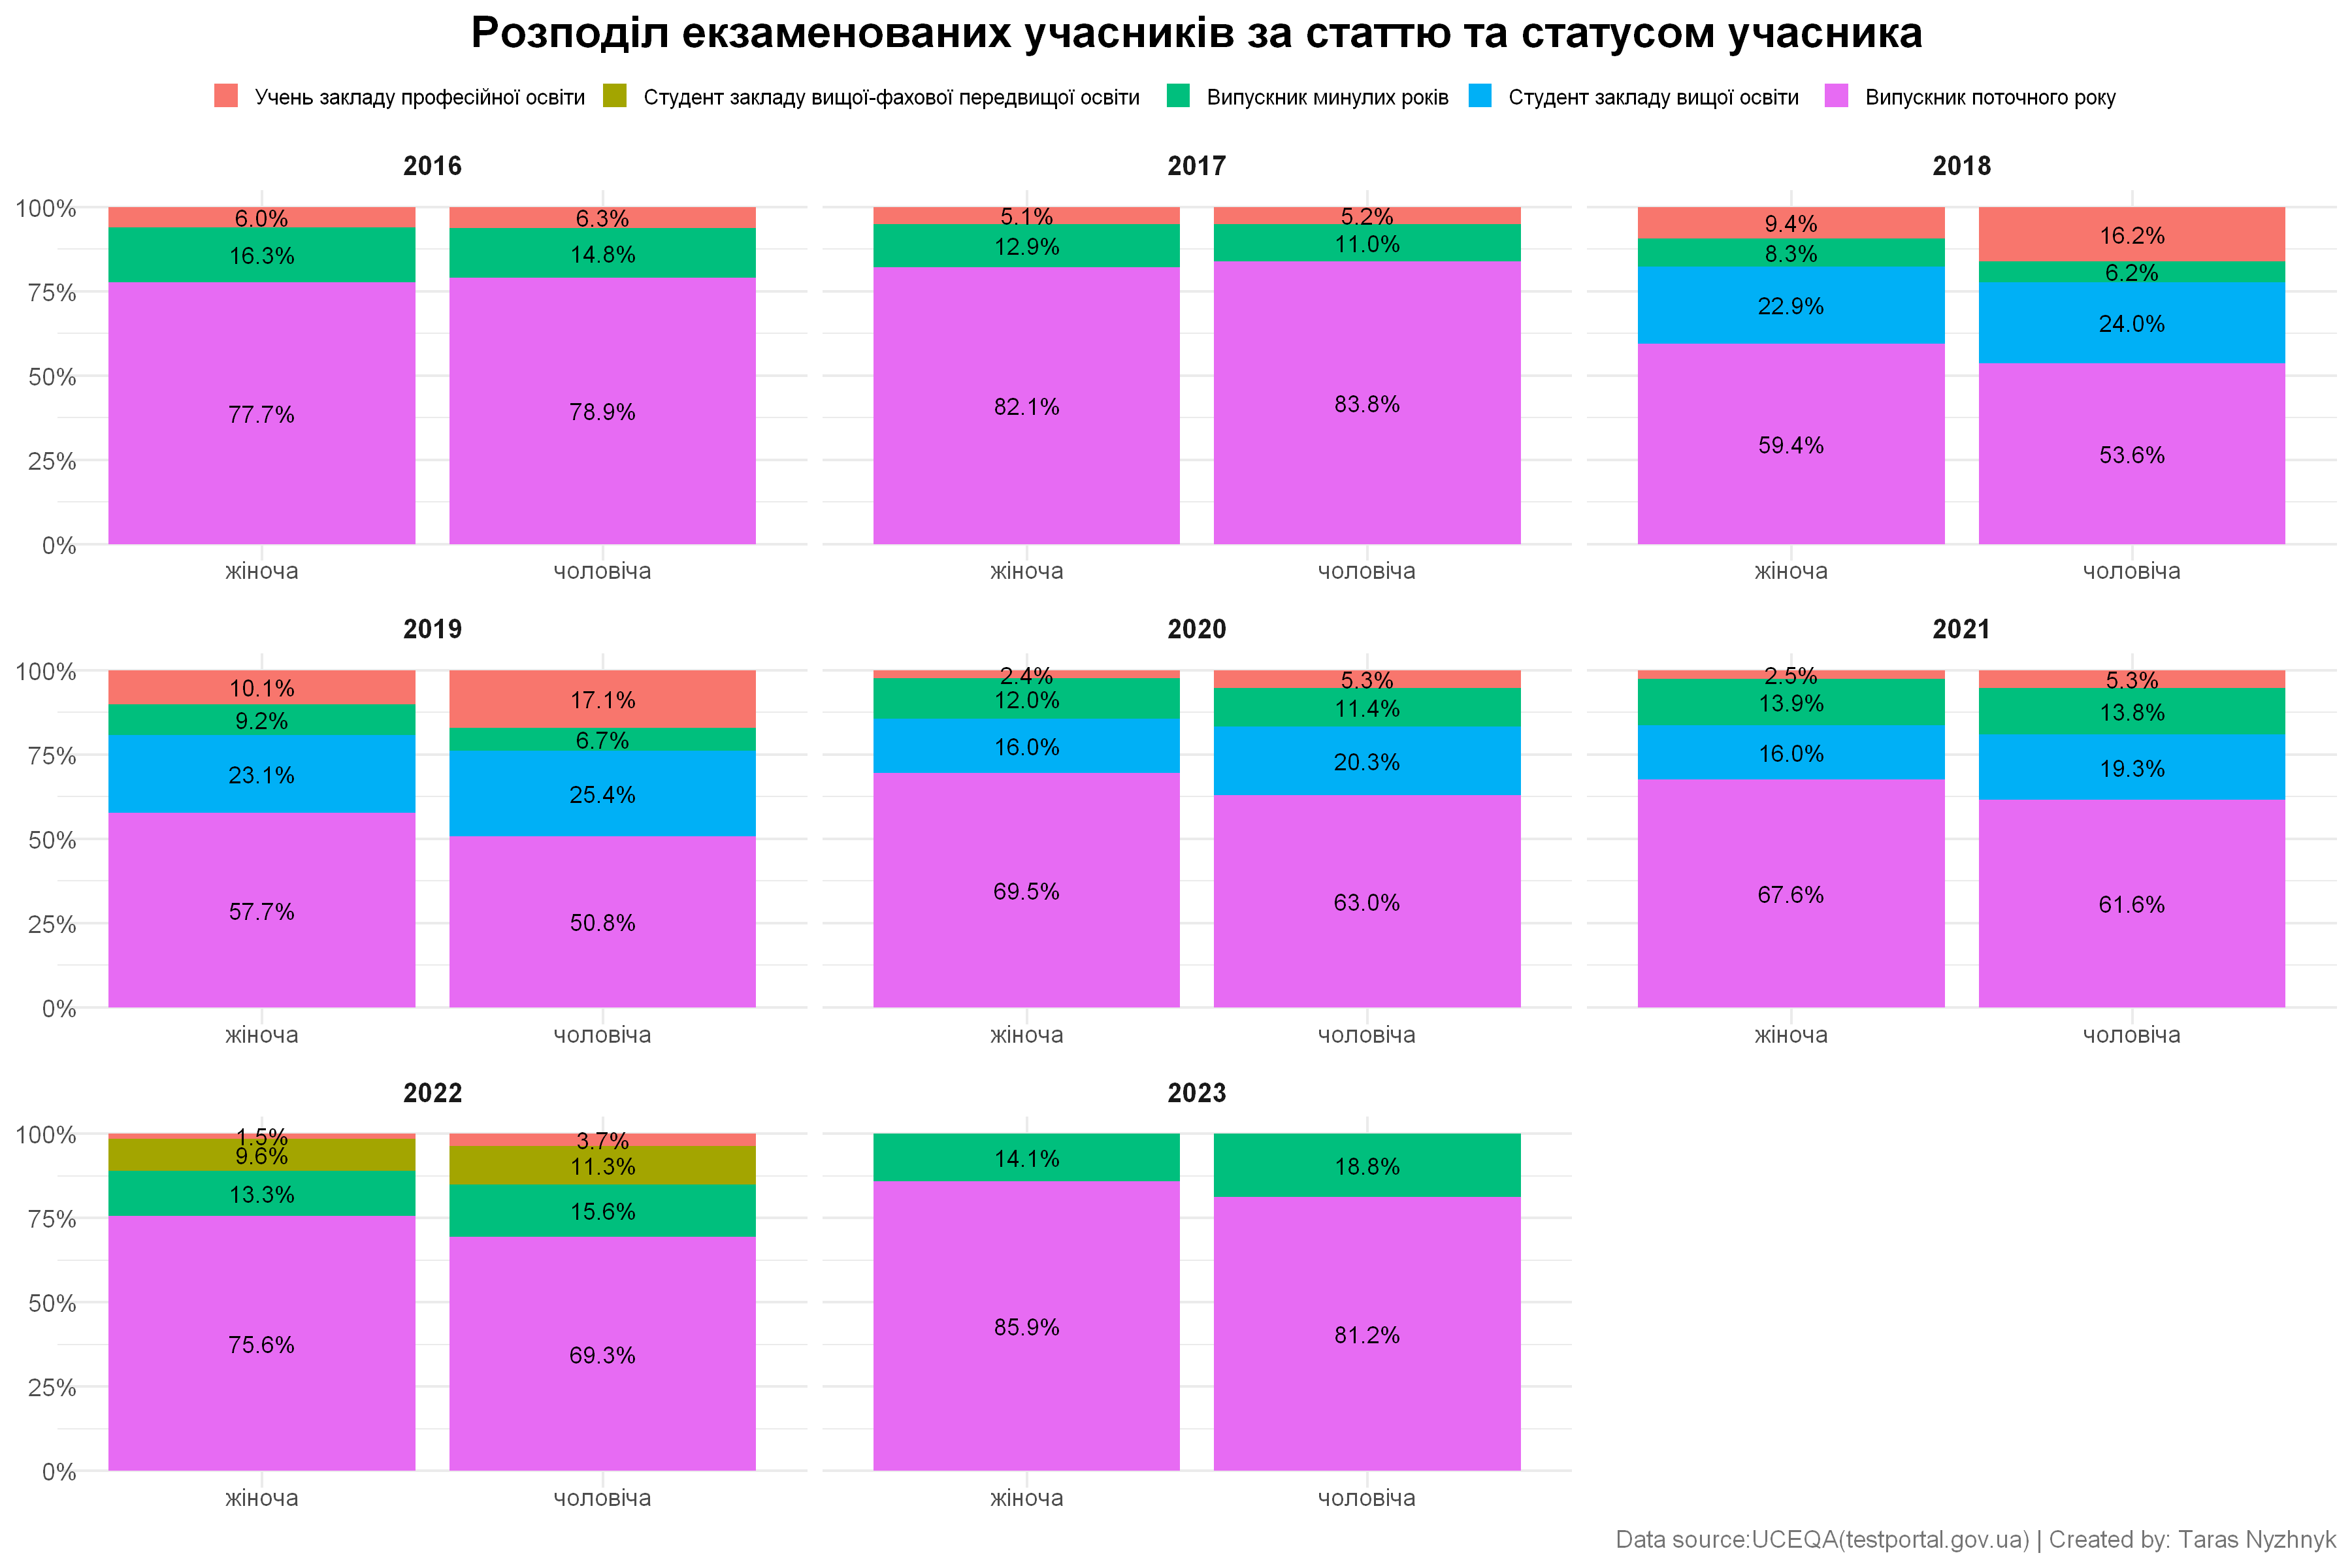

In [29]:
total_students_sex_regtypename <- zno_long_teststatus %>%
  group_by(year, sextypename, regtypename) %>%
  summarize(students = n_distinct(outid), .groups = "drop_last") %>%
  mutate(total_students = sum(students))

ggplot(total_students_sex_regtypename) +
  aes(
    x = sextypename, y = students / total_students,
    fill = forcats::fct_reorder(regtypename, students / total_students)
  ) +
  geom_col(position = position_fill()) +
  geom_text(
    aes(
      label = scales::percent(students / total_students, accuracy = 0.1)
    ),
    size = 3,
    position = position_fill(vjust = 0.5)
  ) +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Стать", fill = "Статус тесту") +
  ggtitle("Розподіл екзаменованих учасників за статтю та статусом учасника") +
  facet_wrap(~year, scales = "free_x", ncol = 3) +
  caption +
  general_plot_config +
  theme(
    axis.text.y = element_text(margin = margin(0, -10, 0, 0)),
    legend.title = element_blank(),
    legend.key.size = unit(10, "pt"),
    legend.margin = margin(10, 30, 0, 0)
  )


### 1.8 Success story of the graduates

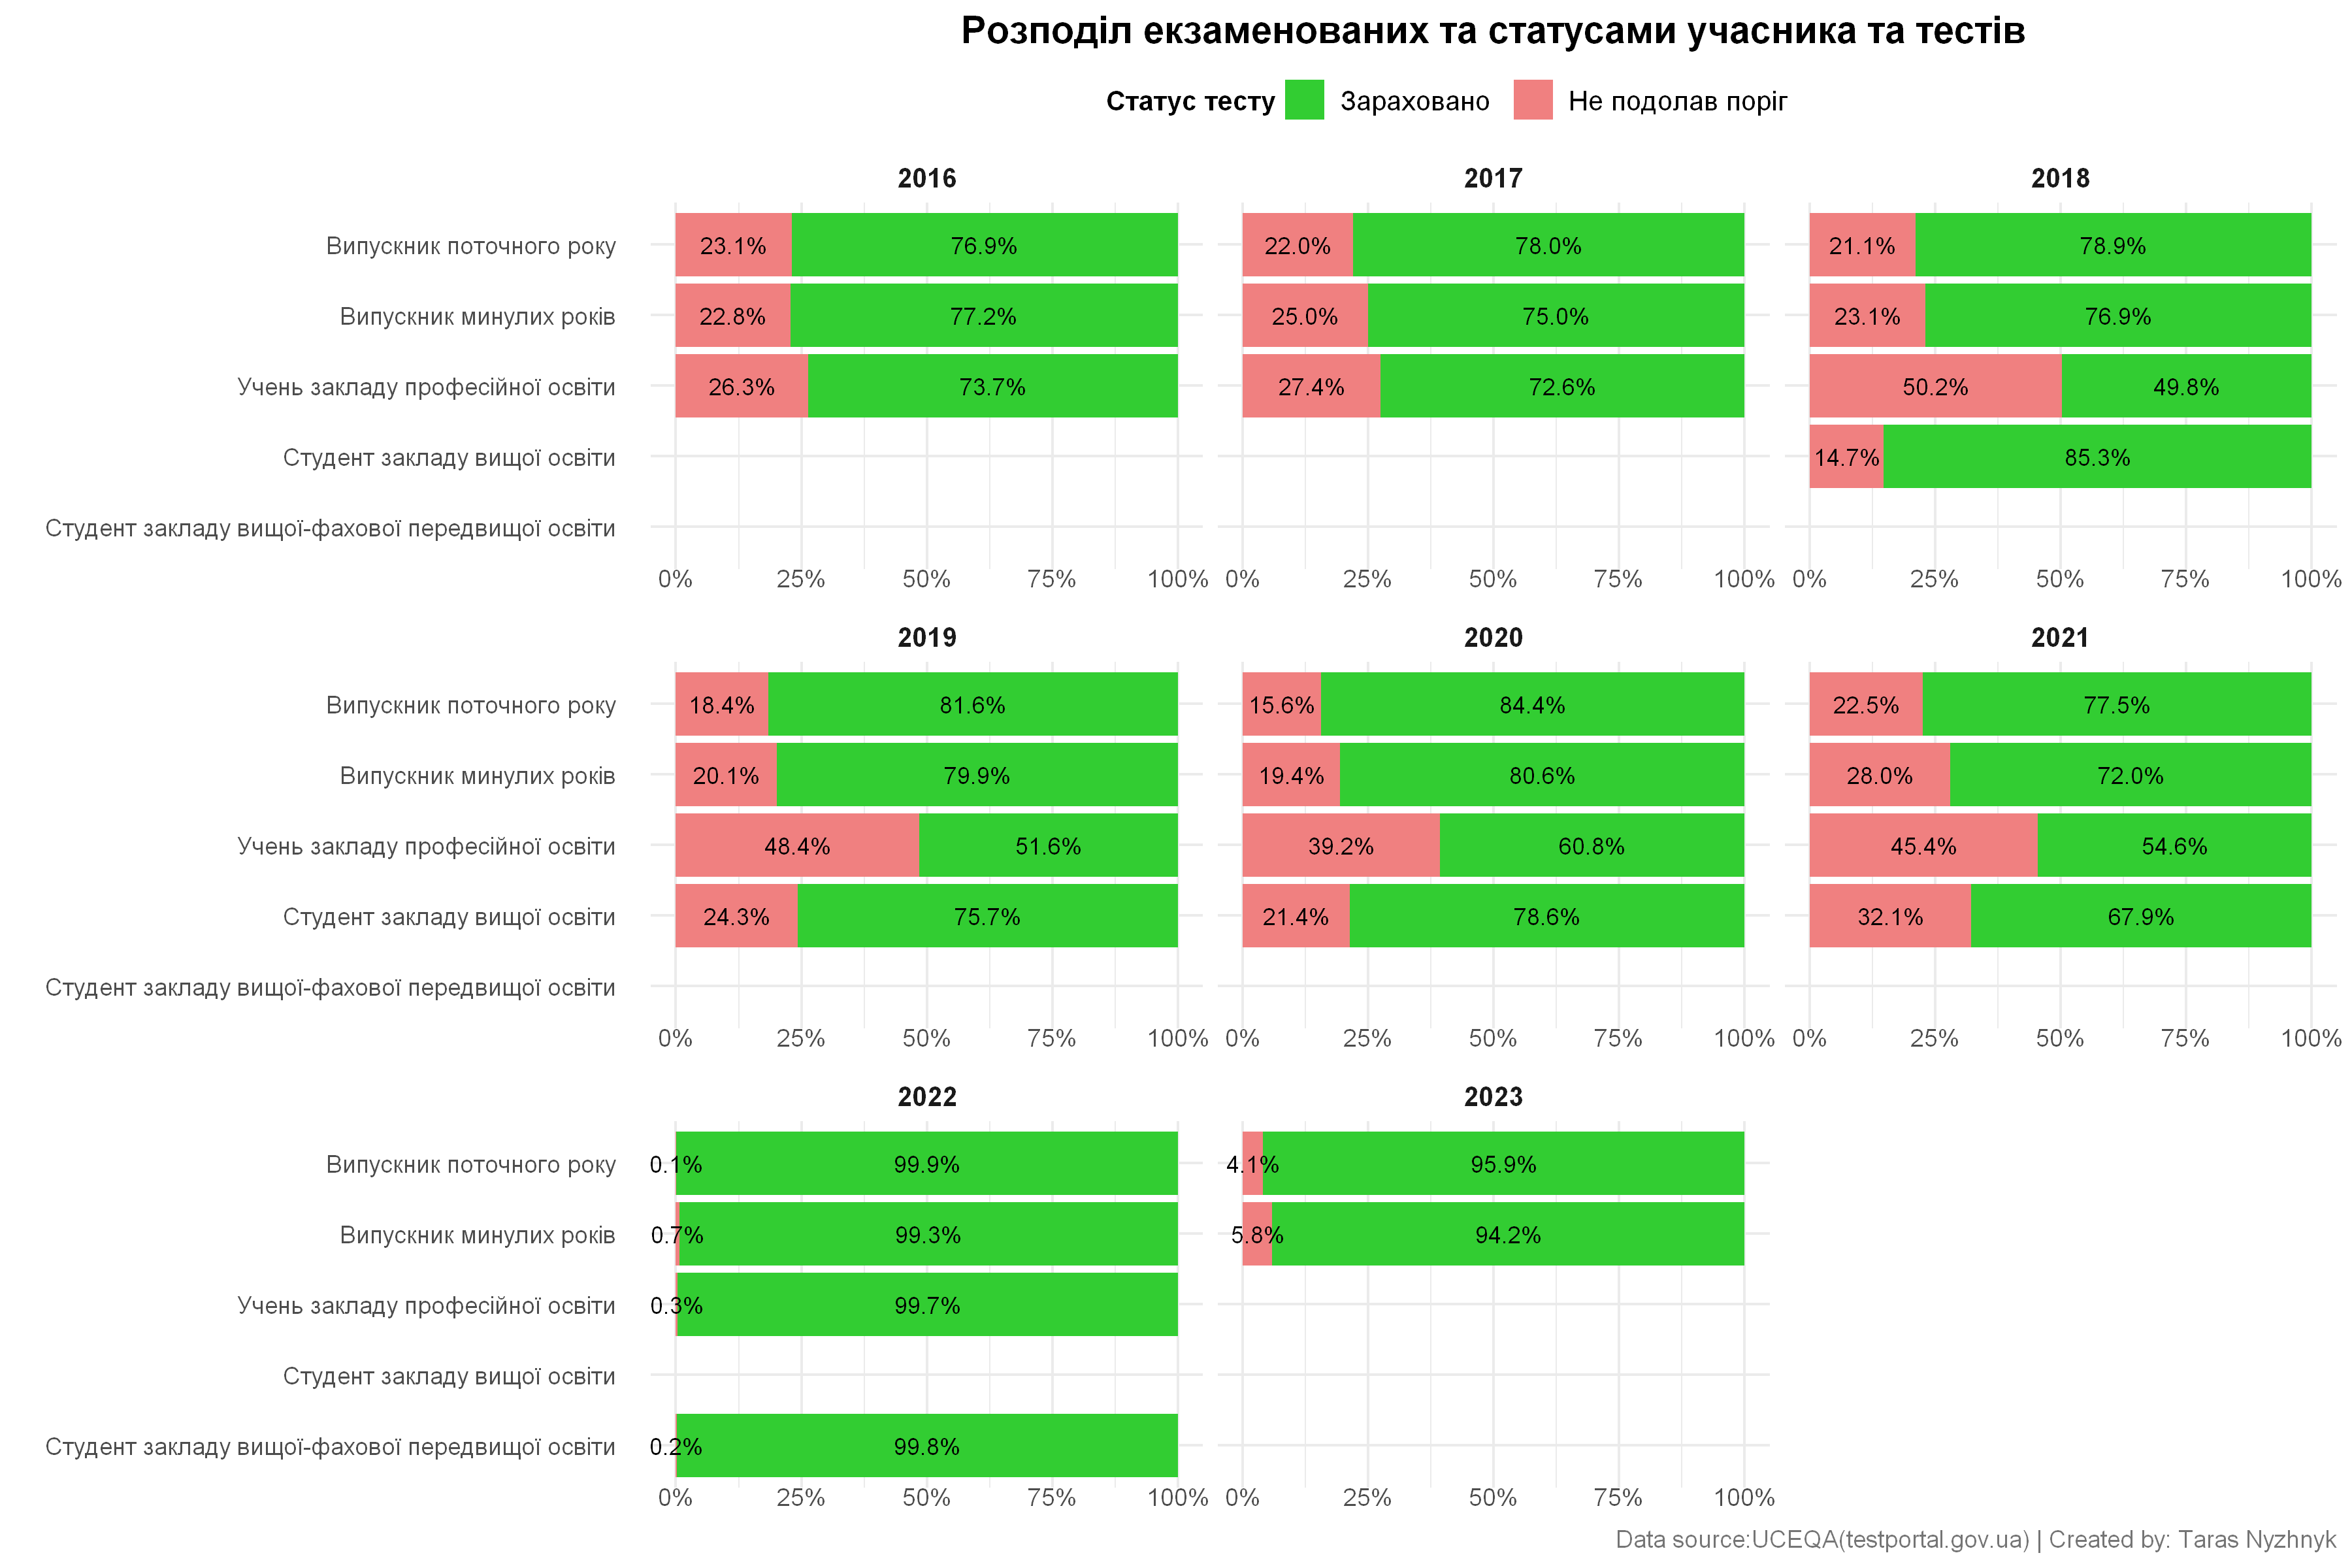

In [30]:
total_students_sex_regtypename <- zno_long_teststatus %>%
  filter(!status %in% failed_statuses) %>%
  group_by(year, regtypename, status) %>%
  summarize(students = n_distinct(outid), .groups = "drop_last") %>%
  mutate(total_students = sum(students))

ggplot(total_students_sex_regtypename) +
  aes(
    x = factor(regtypename, levels = levels_grad),
    y = students / total_students, fill = status
  ) +
  geom_col(position = position_fill()) +
  geom_text(
    aes(
      label = scales::percent(students / total_students, accuracy = 0.1)
    ),
    size = 3,
    position = position_fill(vjust = 0.5)
  ) +
  scale_y_continuous(labels = scales::percent) +
  labs(fill = "Статус тесту") +
  scale_fill_manual(values = c("#32CD32", "#F08080")) +
  ggtitle("Розподіл екзаменованих та статусами учасника та тестів") +
  coord_flip() +
  facet_wrap(~year, scales = "free_x", ncol = 3) +
  caption +
  general_plot_config +
  theme(
    plot.title = element_text(size = 14),
    axis.text.y = element_text(margin = margin(0, 10, 0, 0)),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 10),
    legend.margin = margin(10, 30, 0, 0)
  )


### 1.9 Number of students by subject and test status(mandatory tests)

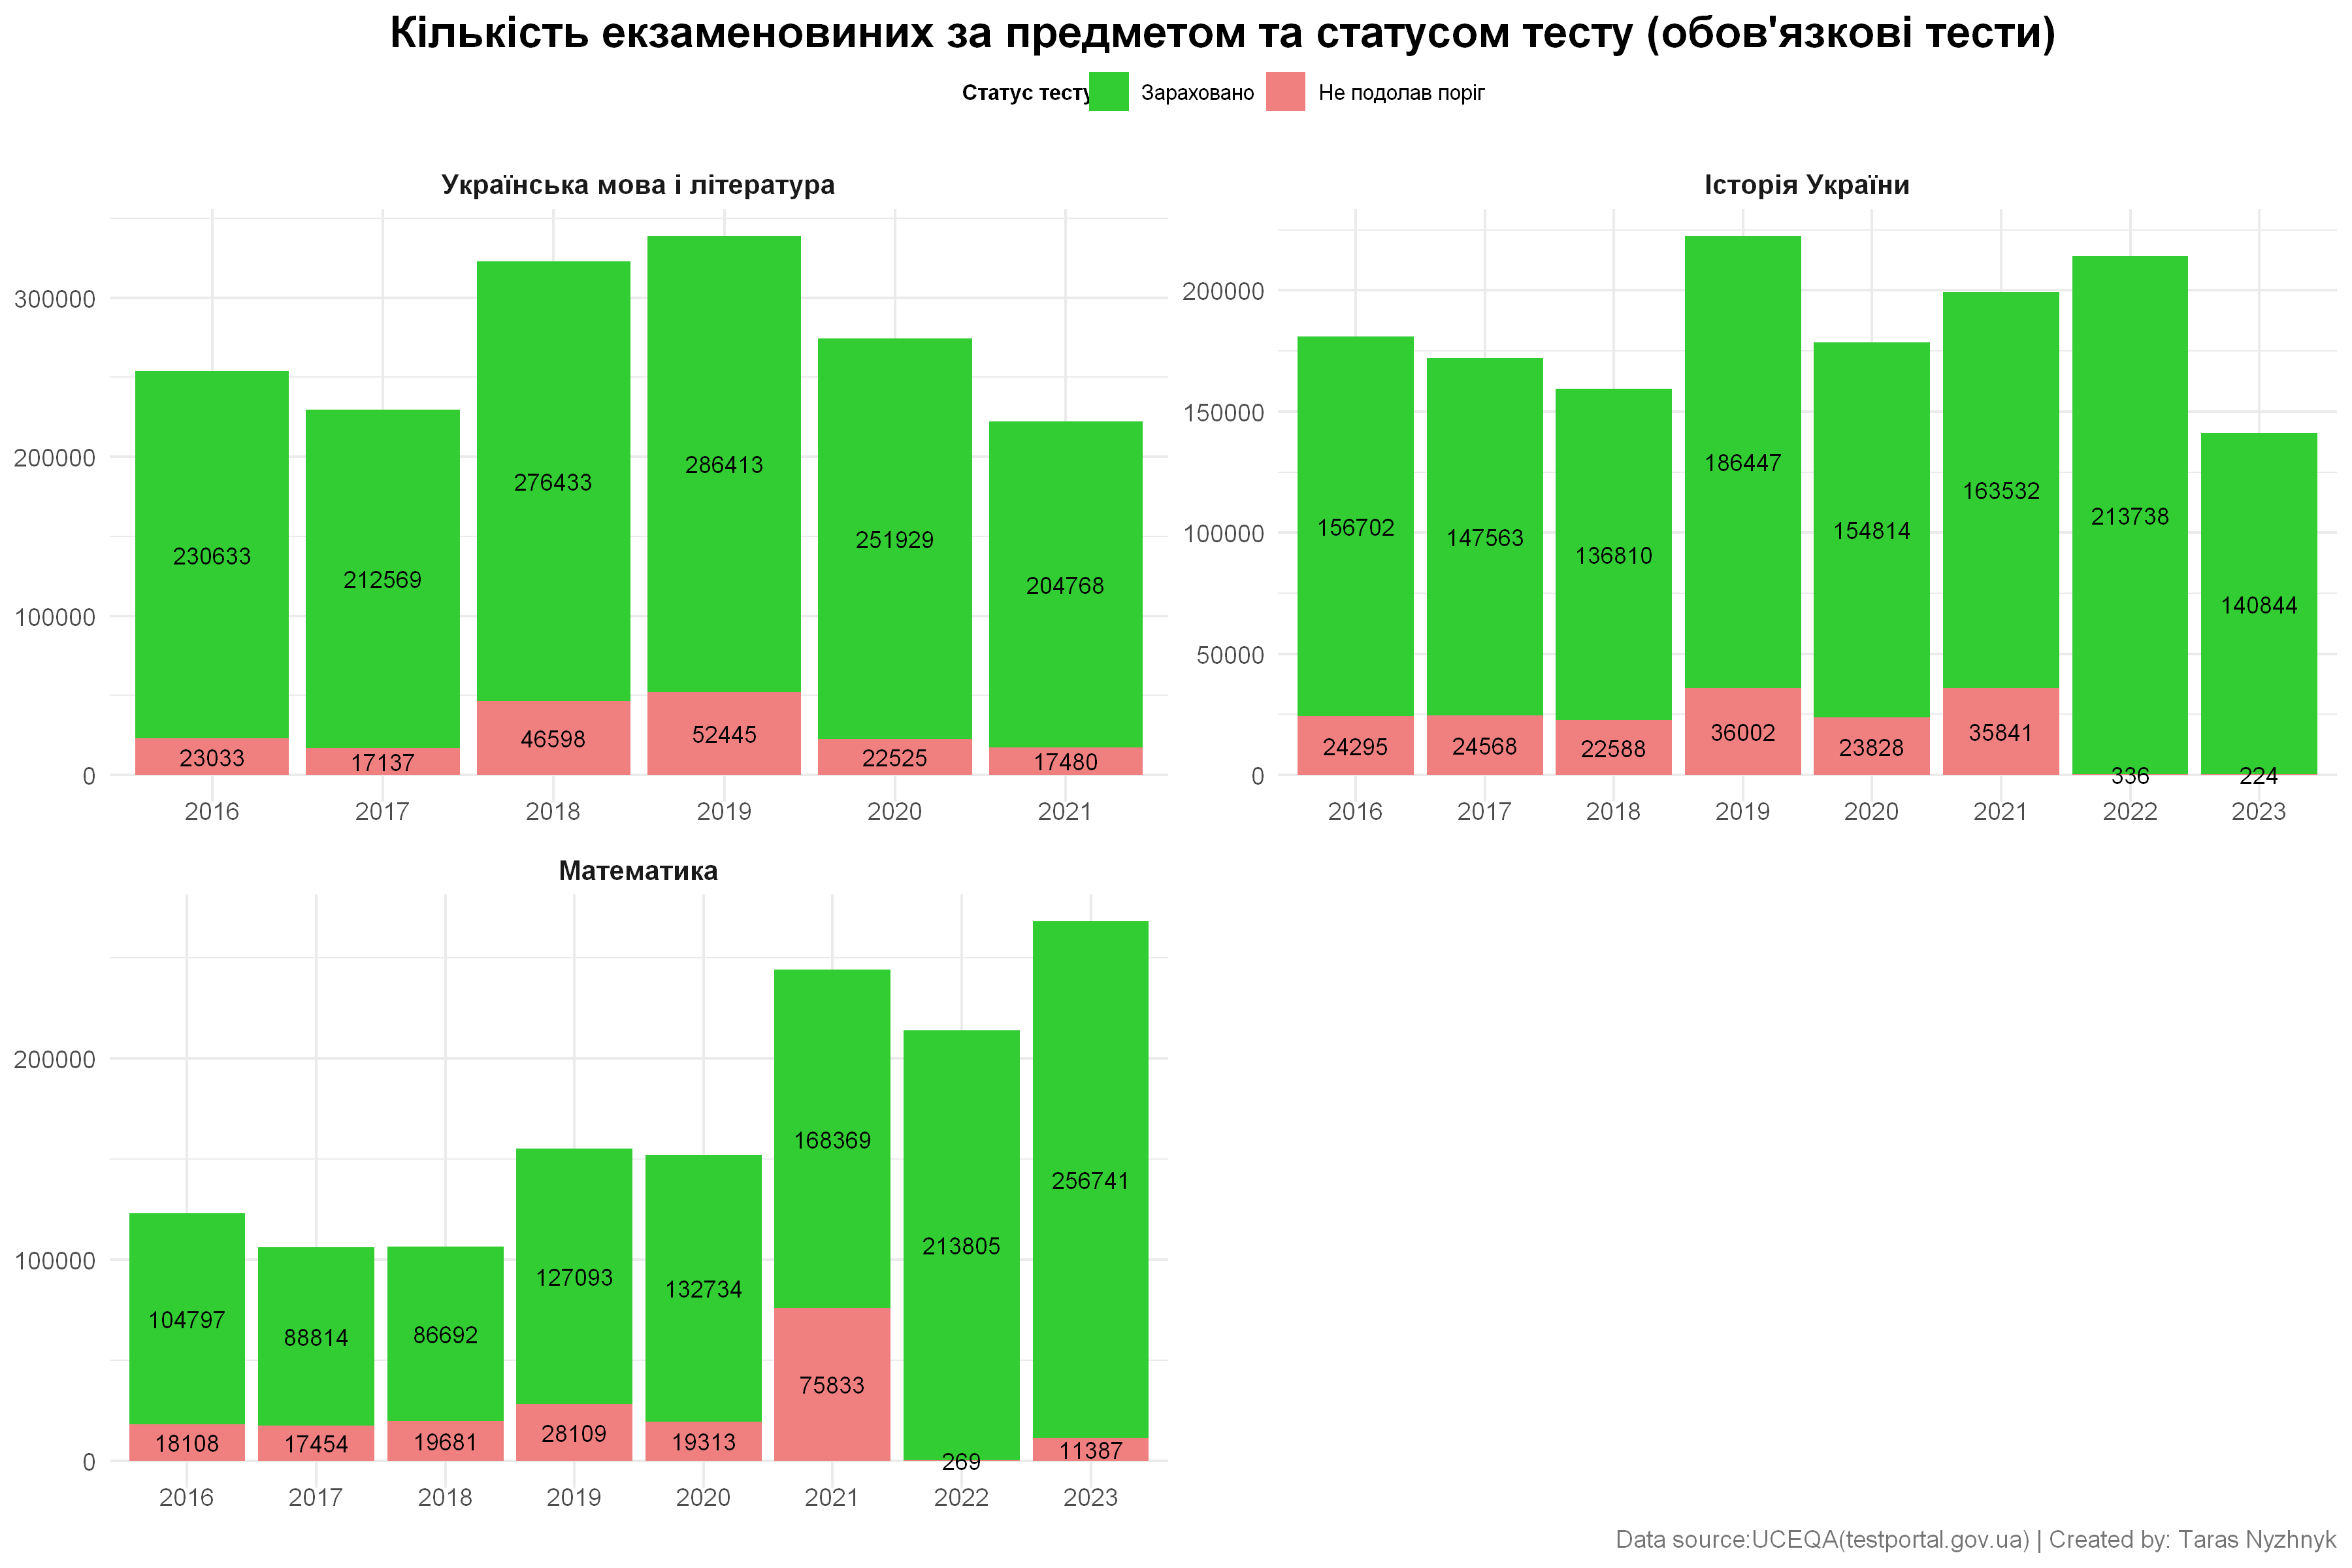

In [31]:
total_st_subj_teststatus_m <- zno_long_teststatus %>%
  filter(!status %in% failed_statuses) %>%
  filter(test %in% levels_m_subj) %>%
  group_by(year, test, status) %>%
  count()

ggplot(total_st_subj_teststatus_m) +
  aes(x = factor(year), y = n, fill = status) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = n), position = position_stack(vjust = 0.5), size = 3) +
  facet_wrap(
    ~ factor(test, levels = levels_m_subj),
    scales = "free",
    ncol = 2
  ) +
  labs(fill = "Статус тесту") +
  ggtitle(
    "Кількість екзаменовиних за предметом та статусом тесту (обов'язкові тести)"
  ) +
  scale_fill_manual(values = c("#32CD32", "#F08080")) +
  caption +
  general_plot_config


### 1.10 Number of students by subject and test status(natural sciences)

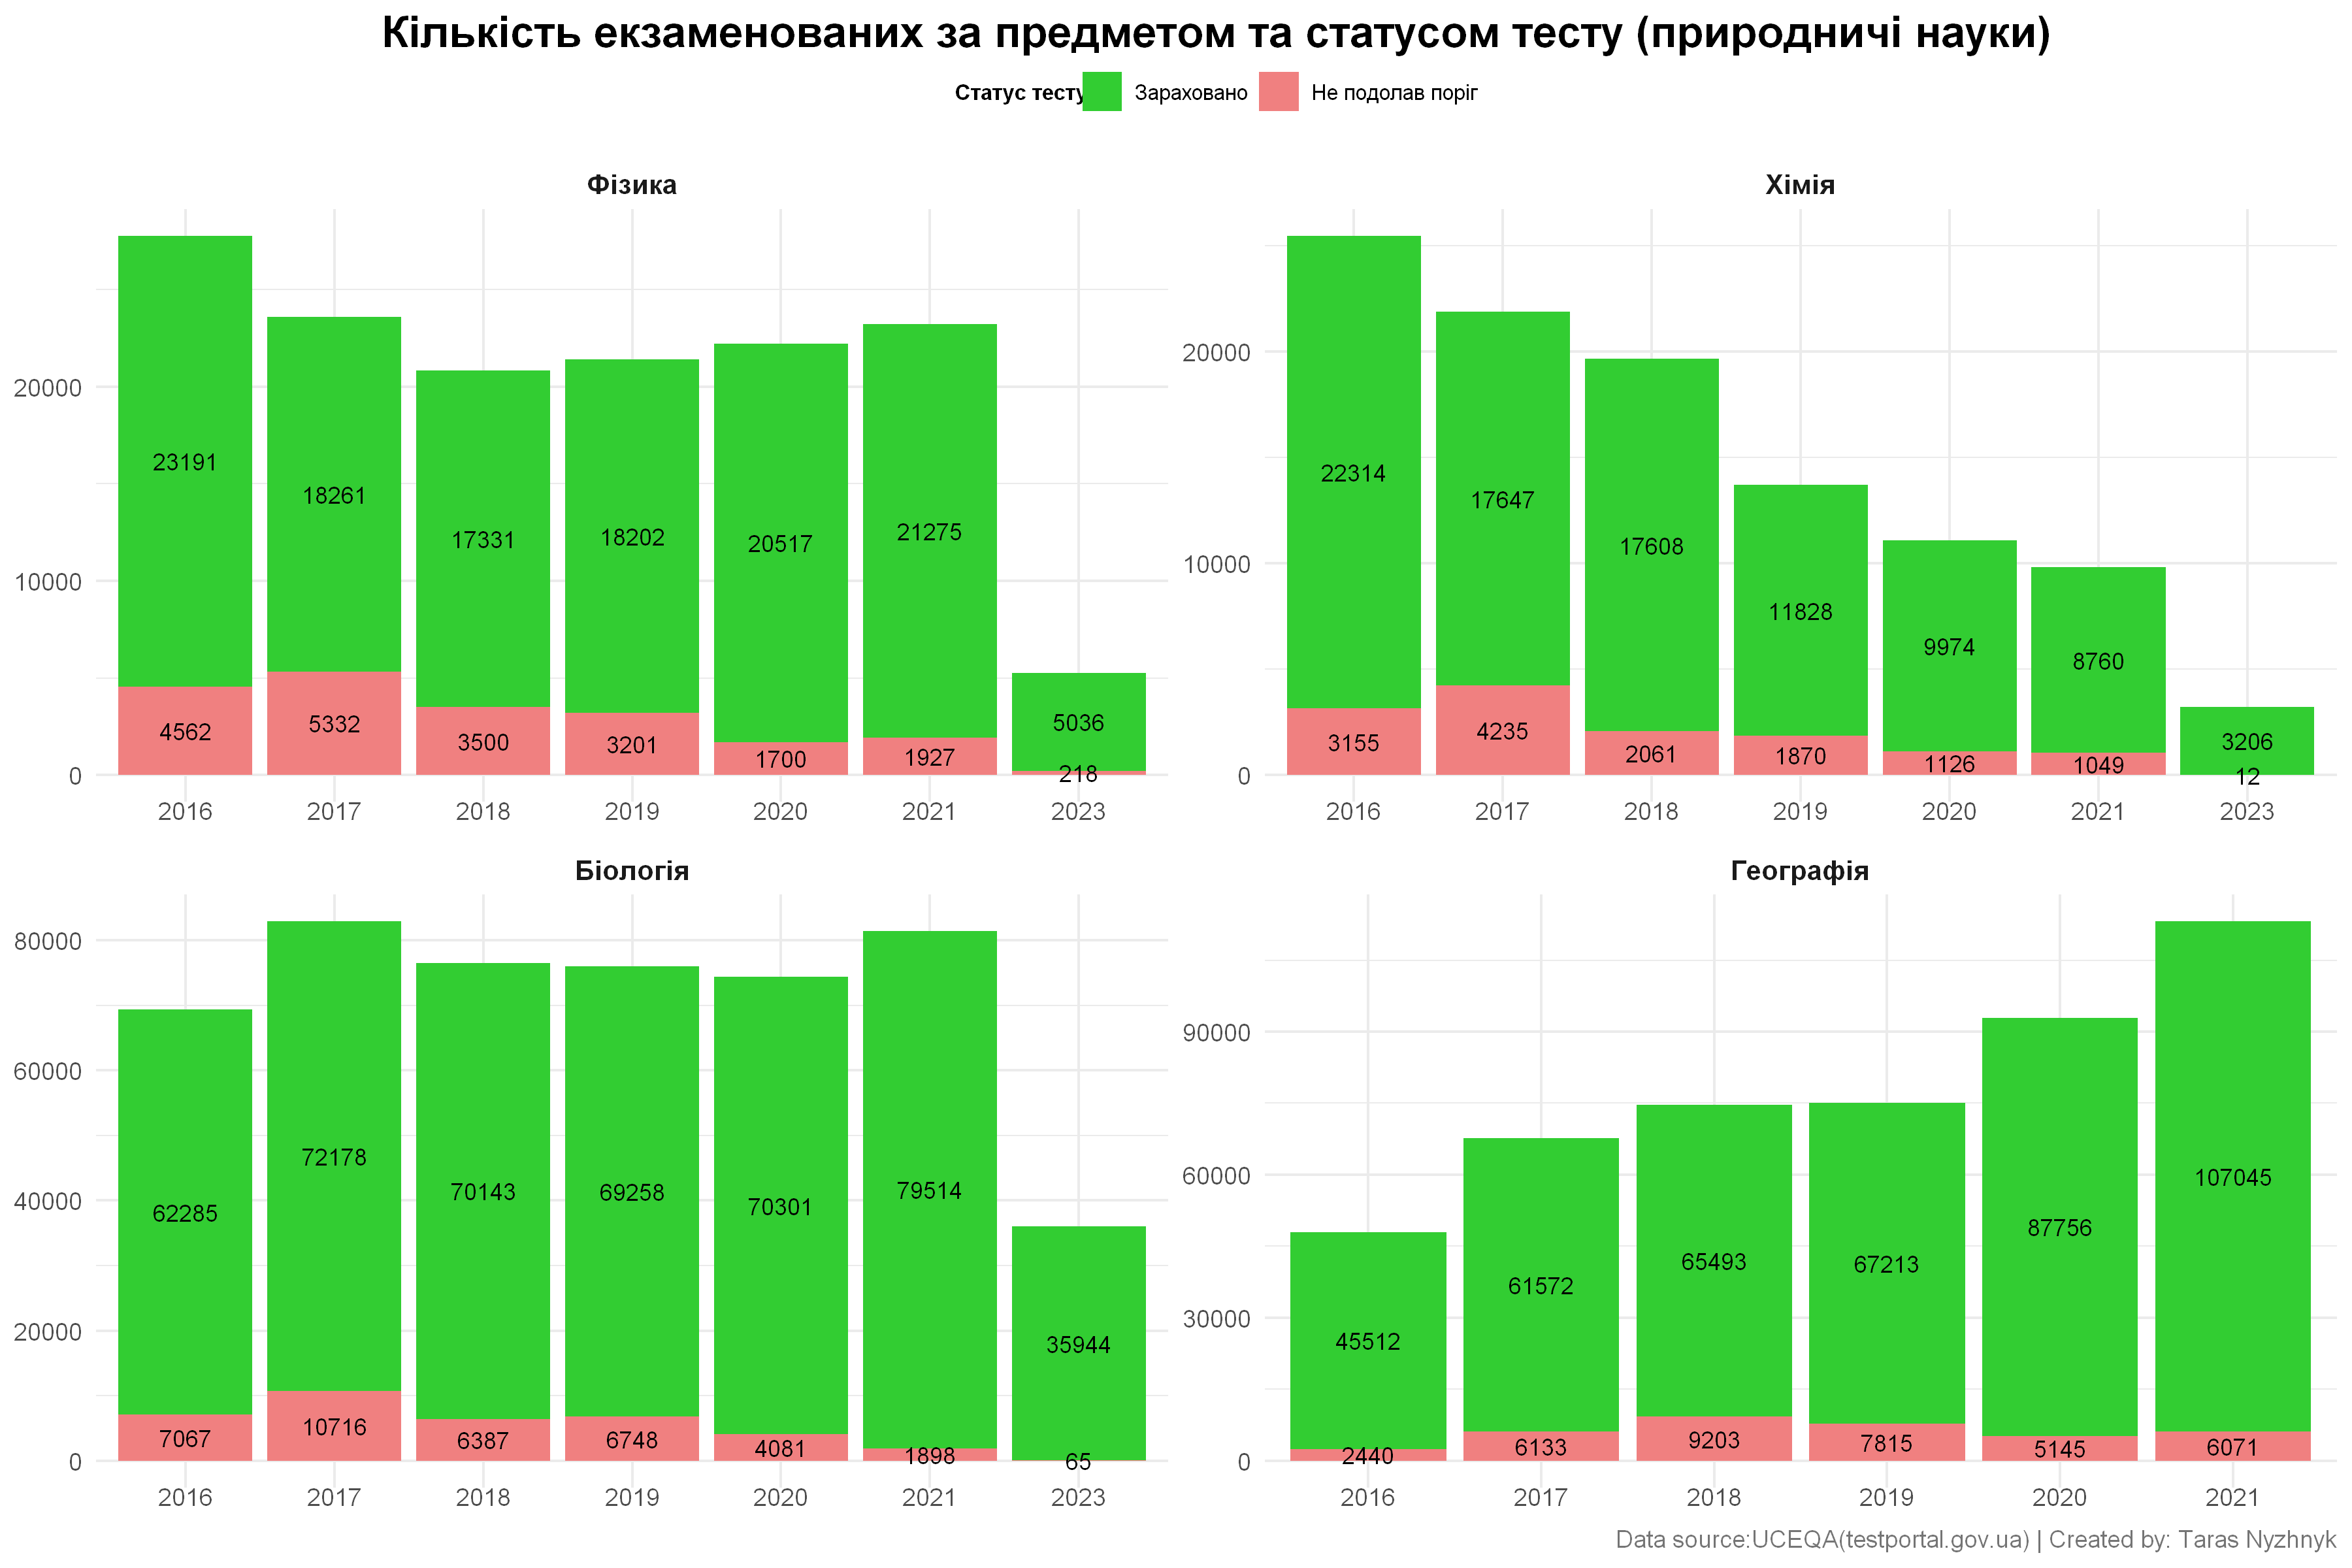

In [32]:
total_st_subj_teststatus_n <- zno_long_teststatus %>%
  filter(!status %in% failed_statuses) %>%
  filter(test %in% levels_n_subj) %>%
  group_by(year, test, status) %>%
  count()

ggplot(total_st_subj_teststatus_n) +
  aes(x = factor(year), y = n, fill = status) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = n), position = position_stack(vjust = 0.5), size = 3) +
  facet_wrap(~test, scales = "free", ncol = 2) +
  labs(fill = "Статус тесту") +
  ggtitle(
    "Кількість екзаменованих за предметом та статусом тесту (природничі науки)"
  ) +
  scale_fill_manual(values = c("#32CD32", "#F08080")) +
  caption +
  general_plot_config


### 1.11 Number of students by subject and test status(languages)

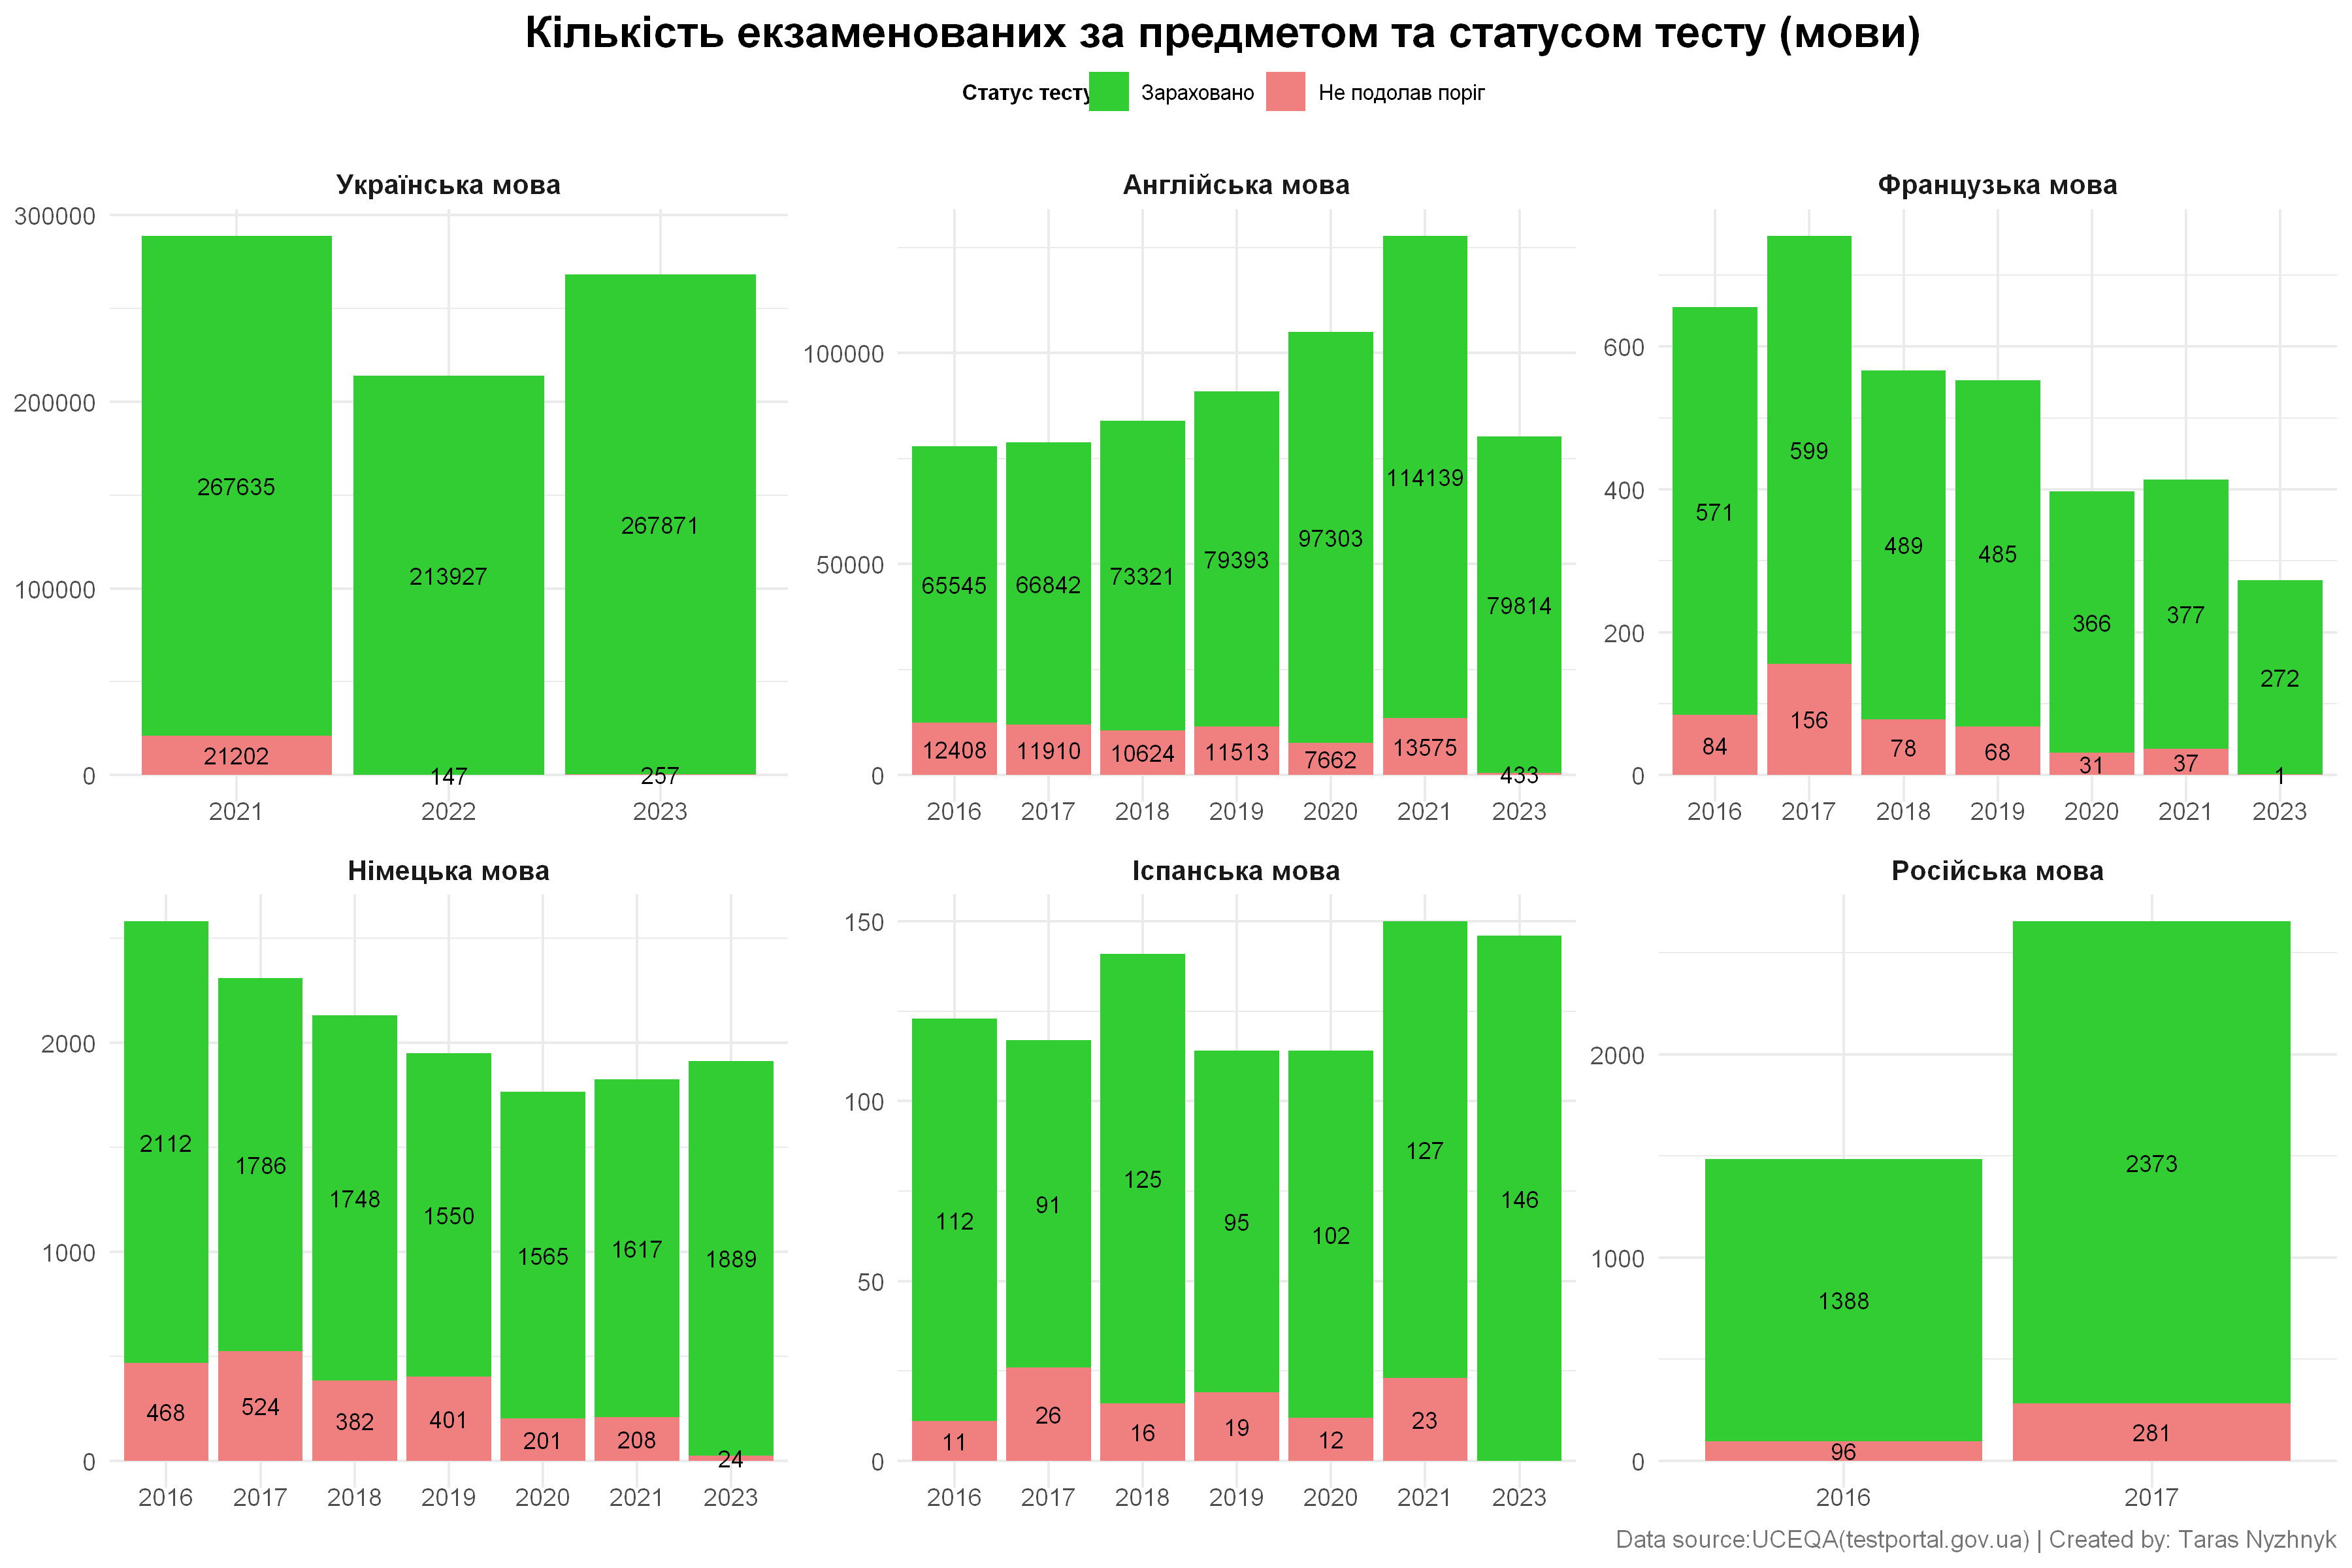

In [33]:
total_st_subj_teststatus_l <- zno_long_teststatus %>%
  filter(!status %in% failed_statuses) %>%
  filter(test %in% levels_l_subj) %>%
  group_by(year, test, status) %>%
  count()

ggplot(total_st_subj_teststatus_l) +
  aes(x = factor(year), y = n, fill = status) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = n), position = position_stack(vjust = 0.5), size = 3) +
  facet_wrap(~test, scales = "free", ncol = 3) +
  labs(fill = "Статус тесту") +
  ggtitle("Кількість екзаменованих за предметом та статусом тесту (мови)") +
  scale_fill_manual(values = c("#32CD32", "#F08080")) +
  caption +
  general_plot_config
